In [1]:
import os
import glob
import numpy as np
import xarray as xr
from scipy.ndimage import rotate
from scipy.stats import linregress
from sklearn.linear_model import LinearRegression

import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec
import matplotlib
matplotlib.rcParams.update({'font.size':15})
%matplotlib inline
from mpl_toolkits.axes_grid1 import make_axes_locatable

import cartopy.crs as ccrs
import cartopy

from mountainUtils import *
from linear_precip_models_2D import *
from tools import *

%load_ext autoreload
%autoreload 2

/global/common/software/m3310/conda/orogprecip/lib/python3.9/site-packages/pyproj/__init__.py:89: UserWarning: pyproj unable to set database path.
  _pyproj_global_context_initialize()


# Functions, data loading

In [2]:
# Monthly data
orogm=xr.open_dataset("data/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81
topo_hires = xr.open_dataarray("data/ETOPO1_Ice_g_gmt4.nc")

imerg_seasmean=xr.open_dataarray("data/GPM-IMERG-seasonalmean-200101-202012.nc")

era5100u_seasmean=xr.open_dataarray("data/e5.climatology.228_246_100u.2001-2020.nc")
era5100v_seasmean=xr.open_dataarray("data/e5.climatology.228_247_100v.2001-2020.nc")

monthnames=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']

### Merge TRMM PR and GPM DPR radar data - those are not provided in the Zenodo archive 
#TRMMPR = xr.open_zarr("data/3A-MO.TRMM.PR.V3-20210325.19980101-20140331.V07A.zarr").precipRateNearSurfaceUnconditional*24 # convert mm/hr to mm/day
#GPMDPR = xr.open_zarr("data/3A-MO.GPM.DPR.V3-20210325.20140401-20201231.V07A.zarr").precipRateNearSurfaceUnconditional*24 # convert mm/hr to mm/day
#merged_radar = xr.concat((TRMMPR,GPMDPR),dim='time').transpose('time','lat','lon').rename({'lat':'latitude','lon':'longitude'})
#merged_radar_seasmean = merged_radar.sel(time=slice("2000-01-01","2021-01-01")).groupby('time.month').mean()
#merged_radar_seasmean.coords['longitude'] = merged_radar_seasmean.coords['longitude'] % 360
#merged_radar_seasmean = merged_radar_seasmean.sortby(merged_radar_seasmean.longitude)
#merged_radar_seasmean = merged_radar_seasmean.reindex(latitude=list(reversed(merged_radar_seasmean.latitude)))
merged_radar_seasmean = xr.open_dataarray("data/3A-MO.TRMM.PR.GPM.DPR.V3-20210325.20010101-20201231.V07A.seasonalmean.nc")

In [3]:
%%time
# Create MountainRange objects; add all data
Ghats      = MountainRange("ghats"      ,[64,82,7,24]   ,"Western Ghats", 70 , [6,7,8], [ 75  ,   9  ,  71.5, 20   ,2], path='data/')
Myanmar    = MountainRange("myanmar"    ,[84,102,7,24]  ,"Myanmar"      , 60 , [6,7,8], [94.5 ,  15  ,  91  , 21   ,2], path='data/')
Myanmar.box_tilted_2 = [97.5, 12, 95.5, 17.5, 2] # Has a more complicated rain band shape that involves two boxes
Vietnam    = MountainRange("vietnam"    ,[100,118,8,25] ,"Vietnam"      , 240, [10,11], [108  ,  18  , 111  , 13   ,2], path='data/')
Malaysia   = MountainRange("malaysia"   ,[96,114,-2,15] ,"Malaysia"     , 225, [11,12], [102.5,   8  , 105.5,  3   ,2], path='data/')
Philippines= MountainRange("philippines",[117,135,5,22] ,"Philippines"  , 225, [11,12], [122.5,  19  , 127  ,  9   ,2], path='data/')
Newbritain = MountainRange("newbritain" ,[145,163,-17,0],"PNG"          , 320, [6,7,8], [154  , - 5.5, 150  , -8.5 ,2], path='data/')

MRs = (Ghats,Myanmar,Vietnam,Malaysia,Philippines,Newbritain)

for MR in MRs:
    print(MR.name)
    # Monthly data
    MR.subset_2dvar('IMERG',imerg_seasmean)          #IMERG precip
    MR.subset_2dvar('MERGED_RADAR_PR',merged_radar_seasmean)#TRMM PR/GPM DPR precip
    MR.subset_2dvar('VAR_100U',era5100u_seasmean)     #ERA5 100m u wind
    MR.subset_2dvar('VAR_100V',era5100v_seasmean)     #ERA5 100m v wind
    MR.subset_2dvar('Z',orogm)                        #ERA5 topography
    MR.subset_2dvar('Z_HR',np.maximum(topo_hires,0.)) #ETOPO1 topography
    MR.set_uperp()                                 #Cross-slope wind
    
    # Daily data
    MR.set_era5_var('128_034_sstk','SST_DAILY')
    MR.set_era5_var('162_071_viwve','VIWVE_DAILY',group='vinteg')
    MR.set_era5_var('162_072_viwvn','VIWVN_DAILY',group='vinteg')
    MR.set_viwvperp()
    MR.set_daily_imerg()
    MR.vars['UBL_DAILY'] = xr.open_dataarray("data/e5.diagnostic.uBL.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name)) # ERA5 u wind averaged surface-900 hPa
    MR.vars['VBL_DAILY'] = xr.open_dataarray("data/e5.diagnostic.vBL.2001-2020.{}.{}.nc".format(MR._monthstr,MR.name)) # ERA5 v wind averaged surface-900 hPa
    MR.set_daily_Bl_vars()
    
    

ghats
myanmar
vietnam
malaysia
philippines
newbritain
CPU times: user 6.53 s, sys: 20.2 s, total: 26.7 s
Wall time: 33.9 s


In [4]:
%%time
# Define rain band masks and average SST, BL, etc. in these masks
for MR in (Ghats,Vietnam,Malaysia,Philippines,Newbritain):
    MR.mask_above_era5 = tilted_rect(MR.vars['VAR_100U'],*MR.box_tilted,reverse=False)
    MR.mask_upstream_era5 = tilted_rect(MR.vars['VAR_100U'],*MR.box_tilted,reverse=True)
    MR.mask_above_gpm = tilted_rect(MR.vars['IMERG_DAILY'],*MR.box_tilted,reverse=False)
    MR.mask_upstream_gpm_plot = tilted_rect_distance(MR.vars['IMERG_DAILY'],*MR.box_tilted[:-1],-0.1,-MR.box_tilted[-1])
# Set Myanmar masks
Myanmar.mask_above_era5 = (tilted_rect(Myanmar.vars['VAR_100U'],*Myanmar.box_tilted) + tilted_rect(Myanmar.vars['VAR_100U'],*Myanmar.box_tilted_2))>0
Myanmar.mask_upstream_era5 = (tilted_rect_distance(Myanmar.vars['VAR_100U'],*Myanmar.box_tilted[:-1],0.,-2) + tilted_rect_distance(Myanmar.vars['VAR_100U'],*Myanmar.box_tilted_2[:-1],0.,-2))>0
Myanmar.mask_upstream_era5 = (Myanmar.mask_upstream_era5*1. - Myanmar.mask_above_era5*1.)>0
Myanmar.mask_above_gpm = (tilted_rect(Myanmar.vars['IMERG_DAILY'],*Myanmar.box_tilted) + tilted_rect(Myanmar.vars['IMERG_DAILY'],*Myanmar.box_tilted_2))>0
Myanmar.mask_upstream_gpm_plot = (tilted_rect_distance(Myanmar.vars['IMERG_DAILY'],*Myanmar.box_tilted[:-1],-0.1,-2) + tilted_rect_distance(Myanmar.vars['IMERG_DAILY'],*Myanmar.box_tilted_2[:-1],-0.1,-2))>0
Myanmar.mask_upstream_gpm_plot = (Myanmar.mask_upstream_gpm_plot*1. - Myanmar.mask_above_gpm*1.)>0

# Average various variables in rain bands or upstream of them
for MR in MRs:
    for varname in 'SST','THETAEB','TL','QL','BL':
        MR.set_spatialmean(varname+'_DAILY','ABOVE',MR.mask_above_era5,box=None)
    MR.set_spatialmean('VIWV_PERP_DAILY','UPSTREAM',MR.mask_upstream_era5,box=None)
    MR.set_spatialmean('IMERG_DAILY','ABOVE',MR.mask_above_gpm,box=None)


/global/common/software/m3310/conda/orogprecip/lib/python3.9/site-packages/xarray/core/computation.py:760: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)


CPU times: user 4.14 s, sys: 9.28 s, total: 13.4 s
Wall time: 15.1 s


In [5]:
# Plotting functions
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

def add_wind(ax,u,v,color='k',width=0.001,scale=600,key=True,ref=100,app='/(m/s2)',pos=(0.87,1.03)):
    ax.coastlines()
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = v.longitude.expand_dims({"latitude":u.latitude})
    n=5
    m=5
    q=ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color=color,width=width,scale=scale)
    if key:
        ax.quiverkey(q, *pos, ref, label='', labelpos='E', coordinates='axes',color='k',angle=90)
    return q

def add_latlon(ax,box,ftz=None):
    ax.set_anchor('W')
    dl=5
    lons=range(dl*(1+(int(box[0])-1)//dl),dl*(int(box[1])//dl)+1,dl)
    lats=range(dl*(1+(int(box[2])-1)//dl),dl*(int(box[3])//dl)+1,dl)
    
    ax.set_xticks(lons, crs=ccrs.PlateCarree())
    ax.set_yticks(lats, crs=ccrs.PlateCarree())
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    ax.xaxis.set_major_formatter(lon_formatter)
    ax.yaxis.set_major_formatter(lat_formatter)
    if ftz:
        ax.tick_params(axis='both', which='major', labelsize=ftz)
    
    ax.set_xlabel("")
    ax.set_ylabel("")

def plot_box(ax,box,c='b'):
    ax.add_patch(mpatches.Rectangle(xy=[box[0], box[2]], width=box[1]-box[0], height=box[3]-box[2],
                                   edgecolor=c,
                                   fill = False,
                                   lw=3,
                                   linestyle='-',
                                   transform=ccrs.PlateCarree()))
    
def lon_360_to_180(ds):
    ds2=ds.copy()
    ds2.coords['longitude'] = (ds2.coords['longitude'] + 180) % 360 -180
    return ds2.sortby(ds2.longitude)

# Fig - Global Precip, wind & topography maps

In [6]:
merged_radar_seasmean_plot    = lon_360_to_180(merged_radar_seasmean)
era5100u_seasmean_plot        = lon_360_to_180(era5100u_seasmean    )
era5100v_seasmean_plot        = lon_360_to_180(era5100v_seasmean    )
orogm_plot                    = lon_360_to_180(orogm                )

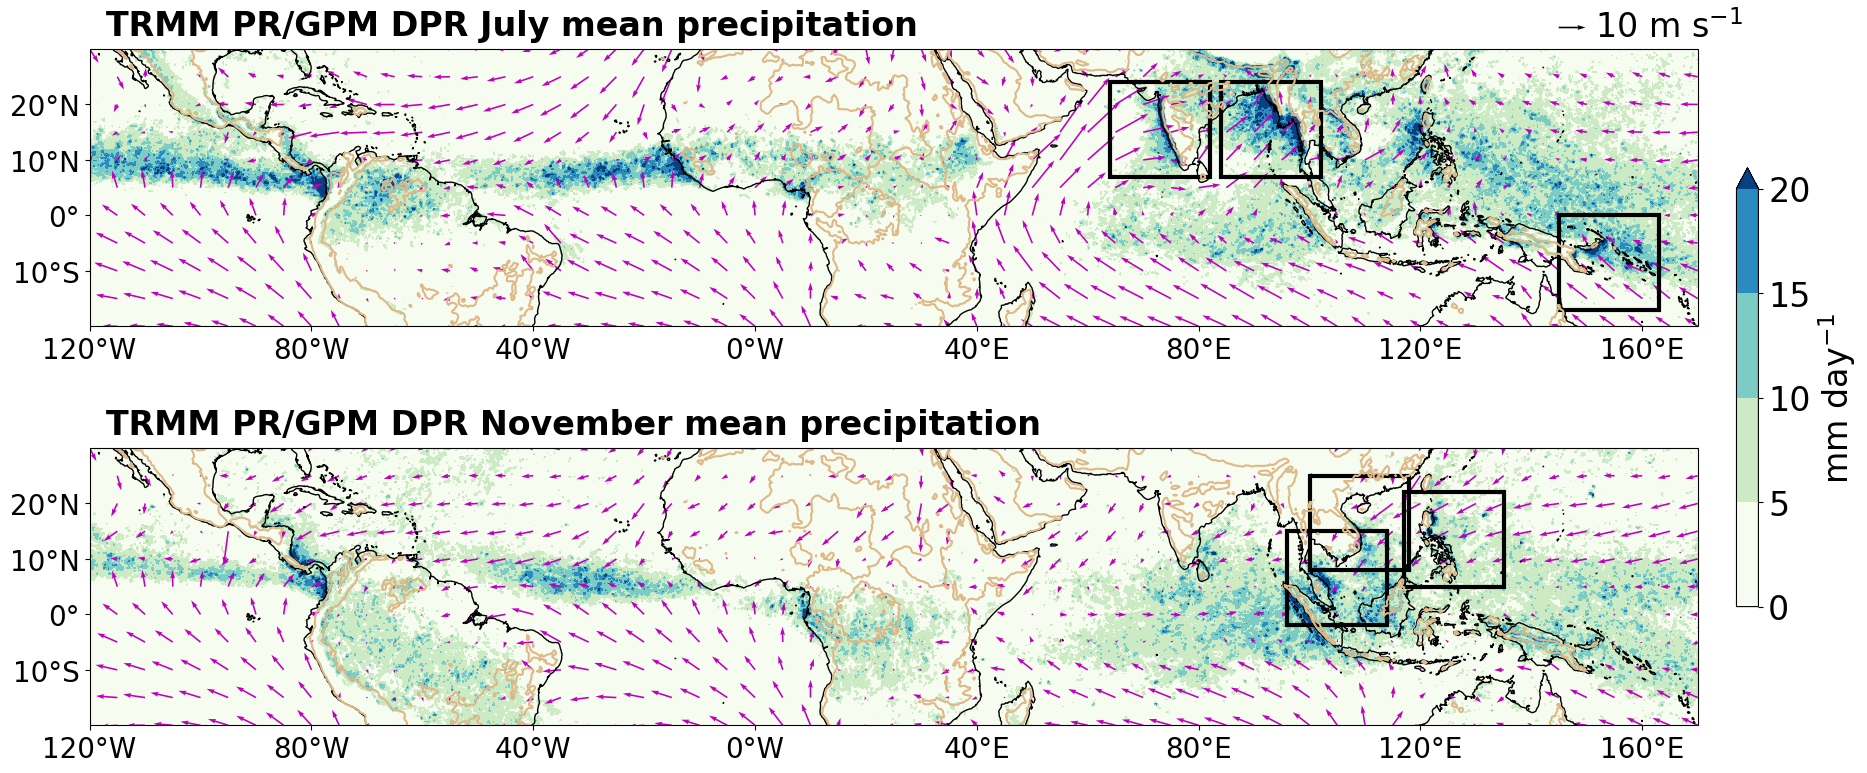

In [7]:
matplotlib.rcParams.update({'font.size': 24})
fig,axs = plt.subplots(2,1,figsize=(25,9.5),subplot_kw = {'projection': ccrs.PlateCarree()})
(ax,ax2)=axs
#Precipitation shadings
im1 = merged_radar_seasmean_plot.sel(month=7,latitude=slice(30,-30),longitude=slice(-120,170)).plot.contourf(ax=ax,levels=np.arange(0.,21.,5.),cmap=plt.cm.GnBu,add_colorbar=False)#,cbar_kwargs={'label':'precip (mm/day)','anchor':[1,-0.5]})
im2 = merged_radar_seasmean_plot.sel(month=11,latitude=slice(30,-30),longitude=slice(-120,170)).plot.contourf(ax=ax2,levels=np.arange(0.,21.,5.),cmap=plt.cm.GnBu,add_colorbar=False)

#wind vectors
n=20
m=n
u=era5100u_seasmean_plot.sel(month=7,latitude=slice(30,-30),longitude=slice(-120,170))
v=era5100v_seasmean_plot.sel(month=7,latitude=slice(30,-30),longitude=slice(-120,170))
X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
Y = u.longitude.expand_dims({"latitude":u.latitude})
Q = ax.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="m",width=0.001,scale=600)

u=era5100u_seasmean_plot.sel(month=11,latitude=slice(30,-30),longitude=slice(-120,170))
v=era5100v_seasmean_plot.sel(month=11,latitude=slice(30,-30),longitude=slice(-120,170))
ax2.quiver(np.array(Y)[::n,::m],np.array(X)[::n,::m], np.array(u)[::n,::m], np.array(v)[::n,::m], transform=ccrs.PlateCarree(),color="m",width=0.001,scale=600)

# Axis cosmetics
for a in ax,ax2:
    orogm_plot.sel(latitude=slice(30,-30),longitude=slice(-120,170)).plot.contour(ax=a,levels=[500.],colors='burlywood',linewidths=[1.5])
    a.coastlines()
    a.set_ylim(-20,30)
    a.set_xlim(-120,170)
    a.set_title("")
    a.set_xticks(range(-120,170,40), crs=ccrs.PlateCarree())
    a.set_yticks(range(-10,30,10), crs=ccrs.PlateCarree())
    a.tick_params(labelsize=20)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    a.xaxis.set_major_formatter(lon_formatter)
    a.yaxis.set_major_formatter(lat_formatter)
    a.set_xlabel("")
    a.set_ylabel("")
    
# Outline region boxes
plot_box(ax,Ghats.box       ,c='k')
plot_box(ax,Myanmar.box     ,c='k')
plot_box(ax,Newbritain.box  ,c='k')
plot_box(ax2,Malaysia.box   ,c='k')
plot_box(ax2,Philippines.box,c='k')
plot_box(ax2,Vietnam.box    ,c='k')

# Reference wind arrow
qk = a.quiverkey(Q, 0.93, 1.08, 10, r'10 m s$^{-1}$', labelpos='E',
                   coordinates='axes',color='k')

# Precip colorbar
cbar = fig.colorbar(im2, ax=axs.ravel().tolist(), shrink=0.6,label=r'mm day$^{-1}$',pad=0.02)

#Panel labels
ax.text(0.01, 1.05,'TRMM PR/GPM DPR July mean precipitation', transform=ax.transAxes,color='k',weight='bold')
ax2.text(0.01, 1.05,'TRMM PR/GPM DPR November mean precipitation', transform=ax2.transAxes,color='k',weight='bold')

fig.savefig('figs/gpmorog.eps',format='eps',bbox_inches='tight')
fig.savefig('figs/gpmorog.png',dpi=70,bbox_inches='tight')

# Fig - Precip, wind & topography maps in regions

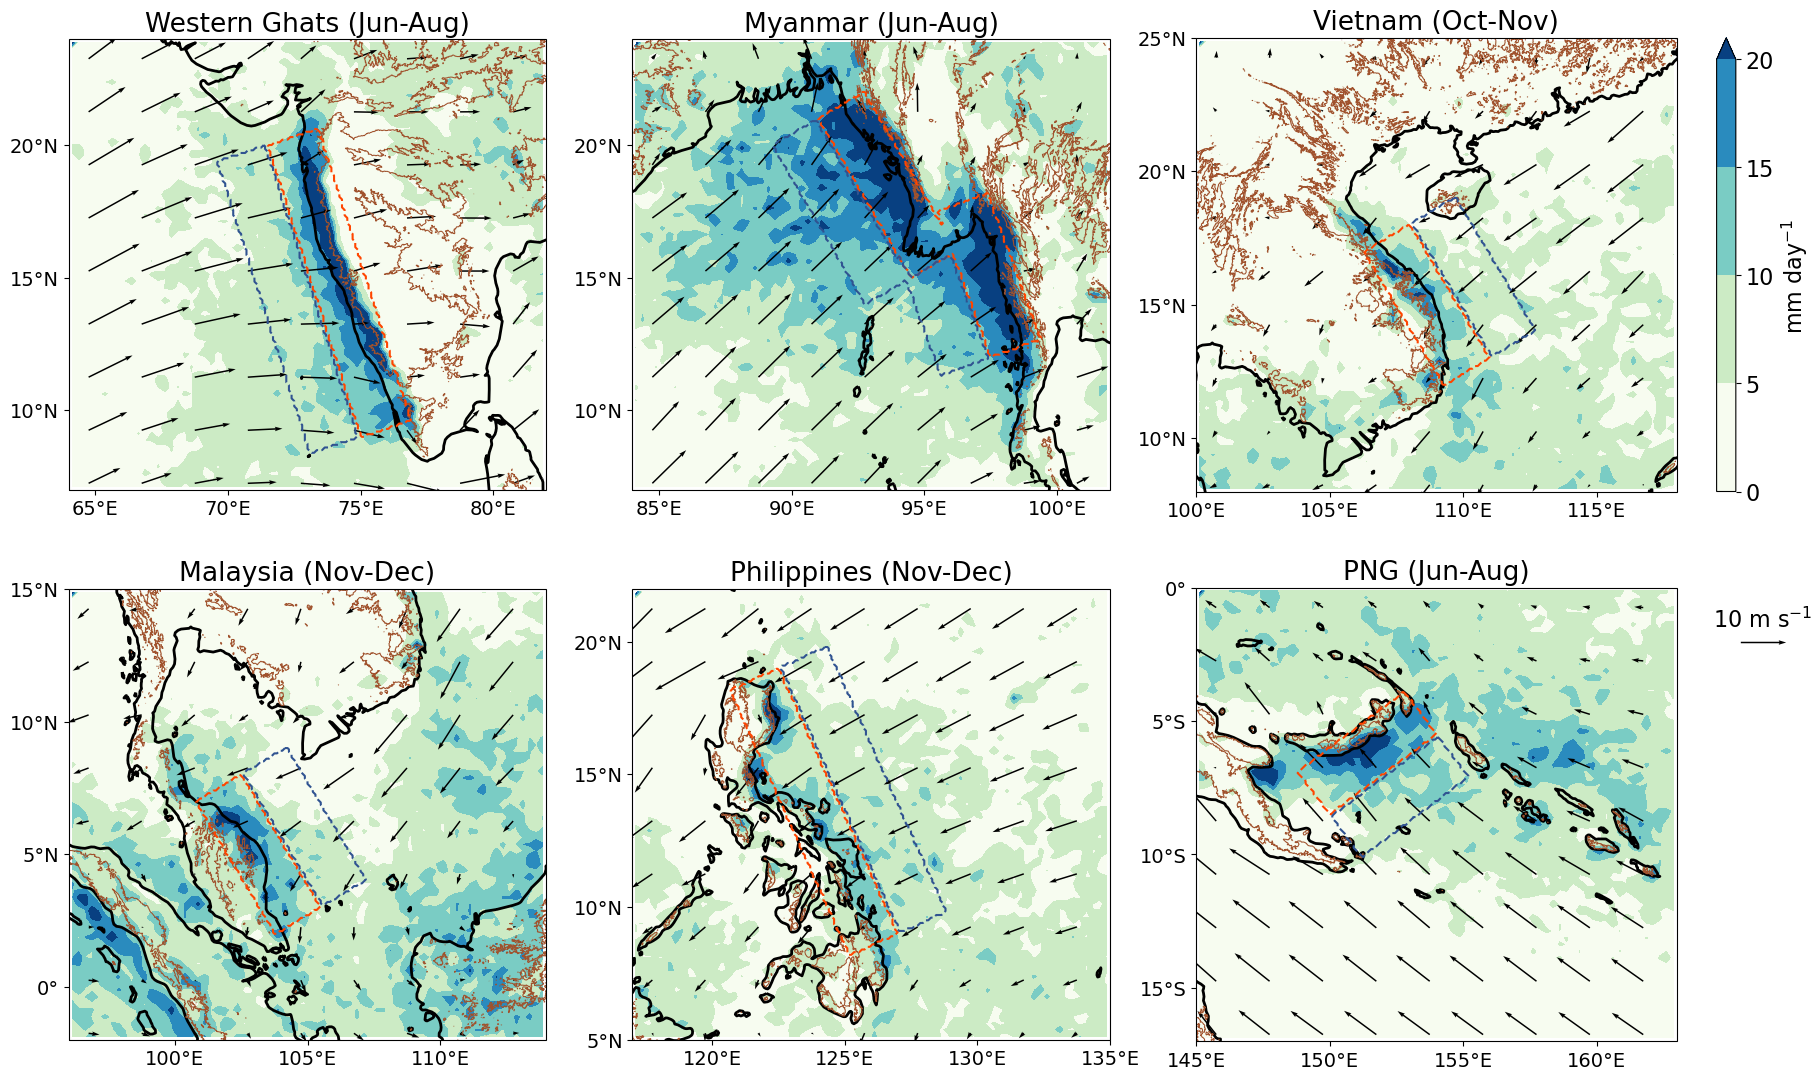

In [8]:
matplotlib.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(18,11))
spec = gridspec.GridSpec(ncols=3, nrows=2, width_ratios= [1,1,1.13],height_ratios=[1,1],figure=fig)
axs=[]
cs=[]
for i,MR in enumerate(MRs):
    ax = fig.add_subplot(spec[i//3,i%3],projection= ccrs.PlateCarree())
    axs.append(ax)
    ax=axs[i]
    ax.coastlines(linewidth=2.)
    box=MR.box
    
    # Plot precip. The pr[0,0]=26. call ensures that one pixel is above the colorbar range, so that color contours are consistent across regions
    pr=MR.vars['MERGED_RADAR_PR']
    pr[0,0]=26.
    c=pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,21.,5.),cmap=plt.cm.GnBu,add_colorbar=False)

    # Plot red and blue dashed boxes
    sel_box(topo_hires,box).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[0.75],colors=['sienna'])
    MR.mask_above_gpm.plot.contour(ax=ax,levels=[0.5],linestyles=['--'],linewidths=[1.5],colors=['orangered'])
    MR.mask_upstream_gpm_plot.plot.contour(ax=ax,levels=[0.5],linestyles=['--'],linewidths=[1.5],colors=['#305391'])
    
    # Wind vectors
    u=sel_months(sel_box(era5100u_seasmean,box),MR.months).mean('month')
    v=sel_months(sel_box(era5100v_seasmean,box),MR.months).mean('month')
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=len(u.latitude)//8
    m=n
    ibeg=3
    iend=-1
    Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=100,scale_units='height',width=1.5,units='dots')
    
    add_latlon(ax,MR.box,ftz=14)
    ax.set_title(MR.Lname +' ('+ monthnames[MR.months[0]-1] +'-'+ monthnames[MR.months[-1]-1]+')',fontsize=19)

# Colorbar
pad=.4;size="4%"
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(c, cax=cax,label=r'mm day$^{-1}$')

# This is used to align bottom&top plots
divider2 = make_axes_locatable(axs[5])
cax2 = divider2.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
cax2.remove()

# Quiver key (reference wind arrow)
qk = axs[5].quiverkey(Q, 1.18, 0.88, 10, r'10 m s$^{-1}$', labelpos='N',
                   coordinates='axes',color='k')

    
fig.tight_layout(pad=0.01,h_pad=0.,w_pad=0.)
fig.savefig('figs/regions.eps',format='eps',bbox_inches='tight')
fig.savefig('figs/regions.png',dpi=70,bbox_inches='tight')


# Fig - Scatterplots

In [9]:
from scipy.optimize import curve_fit
def fit(pred,dep,model='linear'):
    """Given two arrays, perform a nonlinear fit of the form dep = f(pred)
    args :
        - pred: array-like, predictor
        - dep: array-like, dependent variable
        - model: str, either linear, exponential, or softplus
    returns:
        - predrange: an array that samples values in the range of the predictor.
                     Used to plot the 'fit line'
        - fitrange: f(predrange), used to plot the 'fit line'
        - rsq: R-squared of the fit
    """
    predrange = np.linspace(np.min(pred),np.max(pred),41)
    if model=='linear':
        func = lambda x,a,b : a*x+b
    elif model=='exponential':
        func = lambda x,a,b : np.exp(a*x+b)
    elif model=='softplus':
        func = lambda x,a,b : np.log(1+np.exp(a*x+b))
    popt,_ = curve_fit(func,pred,dep)
    fitrange = func(predrange,*popt)
    residual = dep - func(pred,*popt)
    rss = np.sum(residual**2)
    tss = len(dep)*np.var(dep)
    rsq = 1-rss/tss
    return predrange,fitrange,rsq

def select_bootstrap_sample(distribution):
    """Sample a distribution randomly with replacement"""
    n=len(distribution)
    return distribution[np.random.randint(0,n,size=n)]
def bootstrap_CI_mean(data,CI_level,nsamples=1000):
    """Compute a confidence interval for the mean of an array at the level CI_level (0<CI_level<100), 
    using nsamples bootstrap samples"""
    means = np.array([select_bootstrap_sample(data).mean() for _ in range(nsamples)])
    return [np.percentile(means,50-CI_level/2),np.percentile(means,50+CI_level/2)]

def get_binned(a,b,bins,itq=False,bootstrap=False):
    """Calculate conditional averages of b on values of a, within the bins given in argument.
    args :
        - a: array-like, values on the x-axis
        - b: array-like, values on the y-axis, to be averaged conditionally on values of a
        - bins: array-like, must be increasing, defines the edges of bins in which conditional
                averages are taken
        - itq: bool, whether to return interquartile ranges of values of b within the bins
        - bootstrap: mutually exclusive with itq. Whether to return bootstrap estimates of the 95%CI
          of the means of b within the bins.
    returns:
        - bin_centers: centers of the bins given in argument
        - bin_means: averages of b conditioned on a being inside a given bin
        - (if itq) bin_median,bin_q1,bin_q2: median, first quartile, and 3rd quartile of values of b 
           within each bin
        - (if bootstrap) cinf, csup: lower and upper ranges of confidence intervals for the conditional 
          means of b
    """
    idx_bin_inf = max(0,np.argmax(bins>float(a.min()))-1)
    idx_bin_sup = np.argmin(bins<float(a.max()))
    if idx_bin_sup==0 or idx_bin_sup==len(bins)-1:
        bins=bins[idx_bin_inf:]
    else:
        bins=bins[idx_bin_inf:idx_bin_sup+1]
    bin_centers=(bins[1:]+bins[:-1])/2
    digitized = np.digitize(np.array(a), bins)
    bin_means = np.array([np.array(b)[digitized == i].mean() for i in range(1, len(bins))])
    if itq:
        bin_median = np.array([np.median(np.array(b)[digitized == i]) for i in range(1, len(bins))])
        try:
            bin_q1 = np.array([np.quantile(np.array(b)[digitized == i],0.25) for i in range(1, len(bins))])
            bin_q2 = np.array([np.quantile(np.array(b)[digitized == i],0.75) for i in range(1, len(bins))])
        except IndexError:
            bin_q1 = bin_median
            bin_q2 = bin_median
        return bin_centers,bin_means,bin_median,bin_q1,bin_q2
    elif bootstrap :
        cinf_csup =  np.array([bootstrap_CI_mean(np.array(b)[digitized == i],95) for i in range(1, len(bins))])
        return bin_centers,bin_means,cinf_csup[:,0],cinf_csup[:,1]
    else:
        return bin_centers,bin_means
    
def get_count(a,bins):
    """given an array a and a set of bins, return the counts of values of a within each bin"""
    idx_bin_inf = max(0,np.argmax(bins>float(a.min()))-1)
    idx_bin_sup = np.argmin(bins<float(a.max()))
    if idx_bin_sup==0 or idx_bin_sup==len(bins)-1:
        bins=bins[idx_bin_inf:]
    else:
        bins=bins[idx_bin_inf:idx_bin_sup+1]
    bin_centers=(bins[1:]+bins[:-1])/2
    count = np.histogram(a,bins)[0]
    return bin_centers,count

/tmp/ipykernel_630583/22815115.py:65: RuntimeWarning: Mean of empty slice.
  bin_means = np.array([np.array(b)[digitized == i].mean() for i in range(1, len(bins))])
/global/common/software/m3310/conda/orogprecip/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_630583/22815115.py:36: RuntimeWarning: Mean of empty slice.
  means = np.array([select_bootstrap_sample(data).mean() for _ in range(nsamples)])
/tmp/ipykernel_630583/22815115.py:65: RuntimeWarning: Mean of empty slice.
  bin_means = np.array([np.array(b)[digitized == i].mean() for i in range(1, len(bins))])
/global/common/software/m3310/conda/orogprecip/lib/python3.9/site-packages/numpy/core/_methods.py:192: RuntimeWarning: invalid value encountered in divide
  ret = ret.dtype.type(ret / rcount)
/tmp/ipykernel_630583/22815115.py:36: RuntimeWarning: Mean of empty slice.
  means = np.array([select_bootstrap_sample(data).me

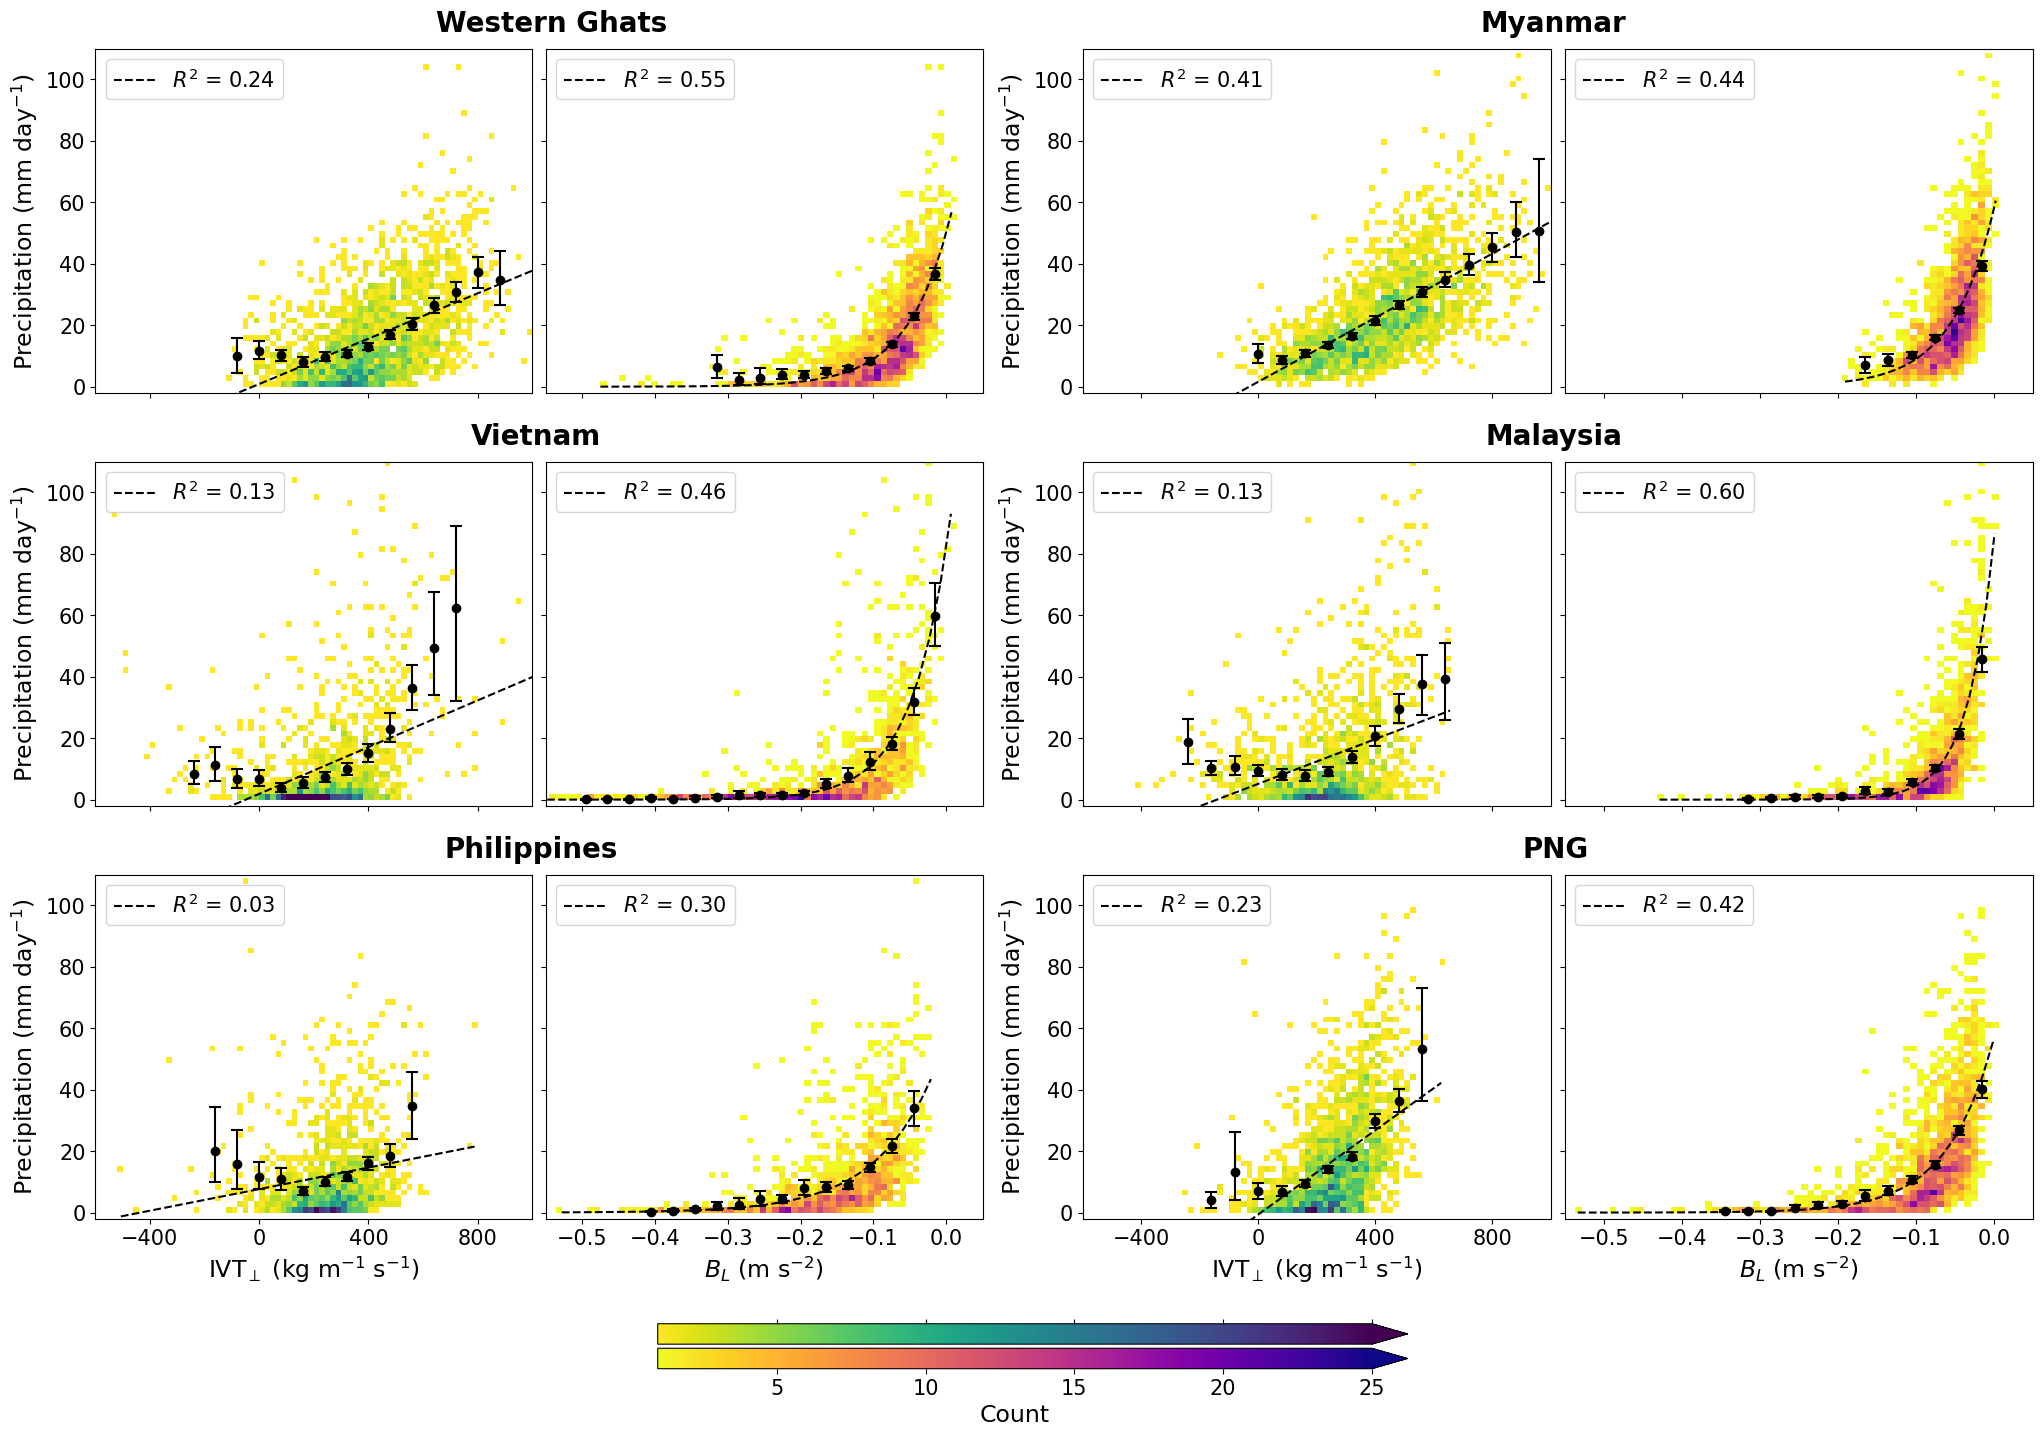

In [10]:
matplotlib.rcParams.update({'font.size':15})
fig = plt.figure(figsize=(25,15))
# create containers
w0=0.03
gs1 = gridspec.GridSpec(3, 2,wspace=w0)
gs2 = gridspec.GridSpec(3, 2,wspace=w0)
gs3 = gridspec.GridSpec(2, 1)

axss1 = [[fig.add_subplot(gs1[i,j]) for j in range(2)] for i in range(3)]
axss2 = [[fig.add_subplot(gs2[i,j]) for j in range(2)] for i in range(3)]
axss = np.array(axss1 + axss2)[[0,3,1,4,2,5]]

axcbar1 = fig.add_subplot(gs3[0,0])
axcbar2 = fig.add_subplot(gs3[1,0])
# now the plots are on top of each other, we'll have to adjust their edges so that they won't overlap
gs1.update(right=0.48)
gs2.update(left=0.52)
gs1.update(bottom=0.1)
gs2.update(bottom=0.1)
gs3.update(bottom=0.)
gs3.update(top=0.03)
gs3.update(left=0.35)
gs3.update(right=0.65)

locs=[0.78,0.85,0.86,0.86,0.8,0.94]
hs=[None,None]

for j,MR in enumerate((Ghats,Myanmar,Vietnam,Malaysia,Philippines,Newbritain)):
    axs = axss[j]
    pr = MR.vars['IMERG_DAILY_ABOVE']
    viwvperp = MR.vars['VIWV_PERP_DAILY_UPSTREAM']
    BL = MR.vars['BL_DAILY_ABOVE']
    
    # For each region, perform 2 fits: linear fit of precip on IVT, and exponential fit of precip on B_L
    for i,(pred,cm,model,bins,bins_hist) in enumerate(zip((viwvperp,BL),(plt.cm.viridis_r,plt.cm.plasma_r),('linear','exponential'),(np.linspace(-600,1000,21),np.linspace(-0.6,0.,21)),(np.linspace(-600,1000,81),np.linspace(-0.65,0.05,81)))):
        hs[i]=axs[i].hist2d(pred,pr, bins=[bins_hist,np.linspace(0.,150,81)], cmin=1,cmap=cm, vmin=1,vmax=25)#, cmin=10)
        
        x,y,rsq = fit(pred,pr,model)
        axs[i].plot(x,y,color='k',linestyle='--',label=r'$R^2$ = %.2f'%rsq)
        centers,means,q02,q98 = get_binned(pred,pr,bins,bootstrap=True)
        _,count = get_count(pred,bins)
        cmin=5
        axs[i].errorbar(centers[count>cmin],means[count>cmin],yerr=[(means-q02)[count>cmin],(q98-means)[count>cmin]],fmt='ok',ecolor='k',capsize=4,ms=6,elinewidth=1.5,capthick=1.5)
        
        axs[i].set_ylabel("Precipitation (mm day$^{-1}$)",fontsize=17)
        axs[i].legend(loc=2)
        axs[i].set_ylim(-2,110)
    axs[0].set_xlabel(r"IVT$_\perp$ (kg m$^{-1}$ s$^{-1}$)",fontsize=17)
    axs[1].set_xlabel(r"$B_L$ (m s$^{-2}$)",fontsize=17)
    axs[0].set_xlim(-600,1000)
    axs[0].set_xticks(range(-400,801,400))
    axs[1].set_xlim(-0.55,0.05)  
    axs[1].set_xticks(np.arange(-0.5,0.1,0.1))
    axs[1].set_ylabel('')
    axs[1].set_yticklabels("")
    axs[0].text(locs[j],1.05,MR.Lname,transform=axs[0].transAxes,fontsize=20,fontweight=600)
    if j<4:
        for i in range(2):
            axs[i].set_xlabel('')
            axs[i].set_xticklabels([])

fig.colorbar(hs[0][-1], cax=axcbar1,label=''     ,orientation='horizontal',extend='max')
fig.colorbar(hs[1][-1], cax=axcbar2,orientation='horizontal',extend='max')
axcbar1.xaxis.tick_top()
axcbar1.set_xticklabels('')
axcbar2.set_xlabel('Count',fontsize=17)

fig.savefig('figs/blscatterplots.eps',format='eps',bbox_inches='tight')
fig.savefig('figs/blscatterplots_hires.png',dpi=300,bbox_inches='tight')
fig.savefig('figs/blscatterplots.png',dpi=70,bbox_inches='tight')


# Fig - British columbia scatterplots

In [11]:
# Load IVT and precip values for the Cascades
Cascades   = MountainRange("cascades"   ,[222,240,43,60],"British Columbia coast range",45 ,[1,11,12],[235,47,227,54,3])
Cascades.vars['VIWVE_DAILY_UPSTREAM'] = xr.open_dataarray("data/e5.oper.an.vinteg.162_071_viwve.ll025sc.2001-2020.01-11-12.cascades.upstreammean.nc")
Cascades.vars['VIWVN_DAILY_UPSTREAM'] = xr.open_dataarray("data/e5.oper.an.vinteg.162_072_viwvn.ll025sc.2001-2020.01-11-12.cascades.upstreammean.nc")
Cascades.vars['VIWV_PERP_DAILY_UPSTREAM'] = crossslopeflow(Cascades.vars['VIWVE_DAILY_UPSTREAM'],Cascades.vars['VIWVN_DAILY_UPSTREAM'],Cascades.angle)
Cascades.set_daily_imerg()
Cascades.set_spatialmean('IMERG_DAILY','above',tilted_rect(Cascades.vars['IMERG_DAILY'],*Cascades.box_tilted,reverse=False),box=None)


In [12]:
# Helper function to plot the inset of the Cascades plot (IMERG PR, winds, and topography)
def plot_prorog(fig,ax,axcbar,MR,box):
    ax.coastlines()
    pr=sel_months(sel_box(imerg_seasmean,box),MR.months).mean('month') # Use IMERG for the Cascades plot as radar data are too sparse
    c=pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,26.,5.),cmap=plt.cm.GnBu,add_colorbar=False)#,cbar_kwargs={'shrink':0.5,'pad':0.02,'label':'Precip. (mm/day)','orientation':'horizontal'})

    #sel_box(orogm,box).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[0.75],colors=['sienna'])
    sel_box(topo_hires,box).coarsen(latitude=10,longitude=10,boundary='trim').mean().plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[0.75],colors=['sienna'])

    u=sel_months(sel_box(era5100u_seasmean,box),MR.months).mean('month')
    v=sel_months(sel_box(era5100v_seasmean,box),MR.months).mean('month')
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=len(u.latitude)//12
    m=n
    ibeg=3
    iend=-1
    Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=100,scale_units='height',width=1.,units='dots')
    fsize=16
    qk = ax.quiverkey(Q, 0.15, -0.05, 10, r'10 m s$^{-1}$',fontproperties={'size':fsize}, labelpos='S',coordinates='axes',color='k')
    fig.colorbar(c,cax=axcbar,orientation='horizontal')
    axcbar.tick_params(axis='both', which='major', labelsize=fsize)
    axcbar.set_xlabel(r'Precip. (mm day$^{-1}$)',fontsize=fsize)


The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


CPU times: user 7.25 s, sys: 1.89 s, total: 9.14 s
Wall time: 8.46 s


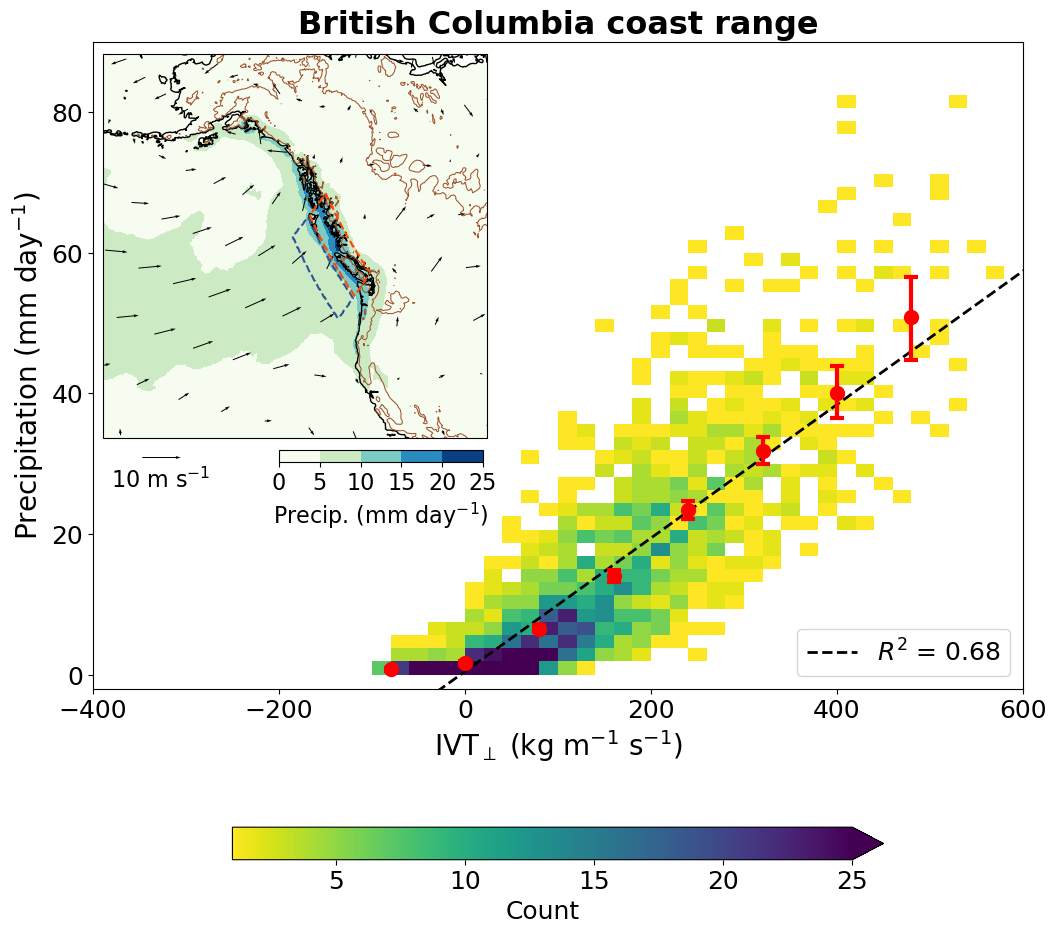

In [13]:
%%time
matplotlib.rcParams.update({'font.size':18})
ft=20
MR=Cascades
pr = MR.vars['IMERG_DAILY_ABOVE']
viwvperp = MR.vars['VIWV_PERP_DAILY_UPSTREAM']
fig = plt.figure(figsize=(12,12))

gs1 = gridspec.GridSpec(1,1)
gs2 = gridspec.GridSpec(1,1)
gs3 = gridspec.GridSpec(1,1)
# Set position of the inset and inset colorbar
gs2.update(bottom=0.55);gs2.update(top=0.87);gs2.update(left=0.087);gs2.update(right=0.5)
gs3.update(bottom=0.53);gs3.update(top=0.54);gs3.update(left=0.28);gs3.update(right=0.45)

ax = fig.add_subplot(gs1[0,0])

proj = ccrs.LambertAzimuthalEqualArea(central_longitude=240.0, central_latitude=50.0)

axmap = fig.add_subplot(gs2[0,0],projection=proj)
axcbar = fig.add_subplot(gs3[0,0])

# Plot inset
plot_prorog(fig,axmap,axcbar,MR,box = [100, 300, 20, 80])
tilted_rect(MR.vars['IMERG_DAILY'],*MR.box_tilted).plot.contour(ax=axmap,transform=ccrs.PlateCarree(),levels=[0.5],linestyles=['--'],linewidths=[1.5],colors=['orangered'])
box_upstream = tilted_rect_distance(MR.vars['IMERG_DAILY'],*MR.box_tilted[:-1],-0.3,-3)
box_upstream.plot.contour(ax=axmap,transform=ccrs.PlateCarree(),levels=[0.5],linestyles=['--'],linewidths=[1.5],colors=['#305391'])
axmap.set_xlim(-3e6,1e6)
axmap.set_ylim(-1.8e6,2.2e6)

# Plot 2d histogram and fit
pred,cm,model,bins,bins_hist = viwvperp,plt.cm.viridis_r,'linear',np.linspace(-600,1000,21),np.linspace(-600,1000,81)
hs=ax.hist2d(pred,pr, bins=[bins_hist,np.linspace(0.,150,81)], cmin=1,cmap=cm, vmin=1,vmax=25)#, cmin=10)
x,y,rsq = fit(pred,pr,model)
ax.plot(x,y,color='k',linestyle='--',linewidth=2.,label=r'$R^2$ = %.2f'%rsq)
centers,means,q02,q98 = get_binned(pred,pr,bins,bootstrap=True)
_,count = get_count(pred,bins)
cmin=5
ax.errorbar(centers[count>cmin],means[count>cmin],yerr=[(means-q02)[count>cmin],(q98-means)[count>cmin]],fmt='or',ecolor='r',ms=10,capsize=5,elinewidth=3,capthick=3)
ax.set_ylabel(r"Precipitation (mm day$^{-1}$)",fontsize=ft)
ax.legend(loc=4)
ax.set_ylim(-2,90)
    
ax.set_xlabel(r"IVT$_\perp$ (kg m$^{-1}$ s$^{-1}$)",fontsize=ft)
ax.set_xlim(-400,600)
ax.set_xticks(range(-400,601,200))
ax.set_title(MR.Lname,fontsize=23,fontweight=600)

fig.colorbar(hs[-1], ax=ax,label='Count',orientation='horizontal',extend='max',shrink=0.7)

fig.savefig('figs/bccoast.eps',format='eps',bbox_inches='tight')
fig.savefig('figs/bccoast.png',dpi=70,bbox_inches='tight')


# Figs - Controls of $B_L$ variations

In [14]:
# Evaluating slopes theoretically
alpha = 20.6/3600*2.5e6
dBLdqL = 1/(11.3*3600)*1004*8000/alpha
dBLdTL = -1/(2.7*3600)*1004*8000/alpha
dBLdeb = 1/(11.5*3600)*1004*8000/alpha

## Regress $B_L$ on $\theta_{eB}, T_L, q_L$

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


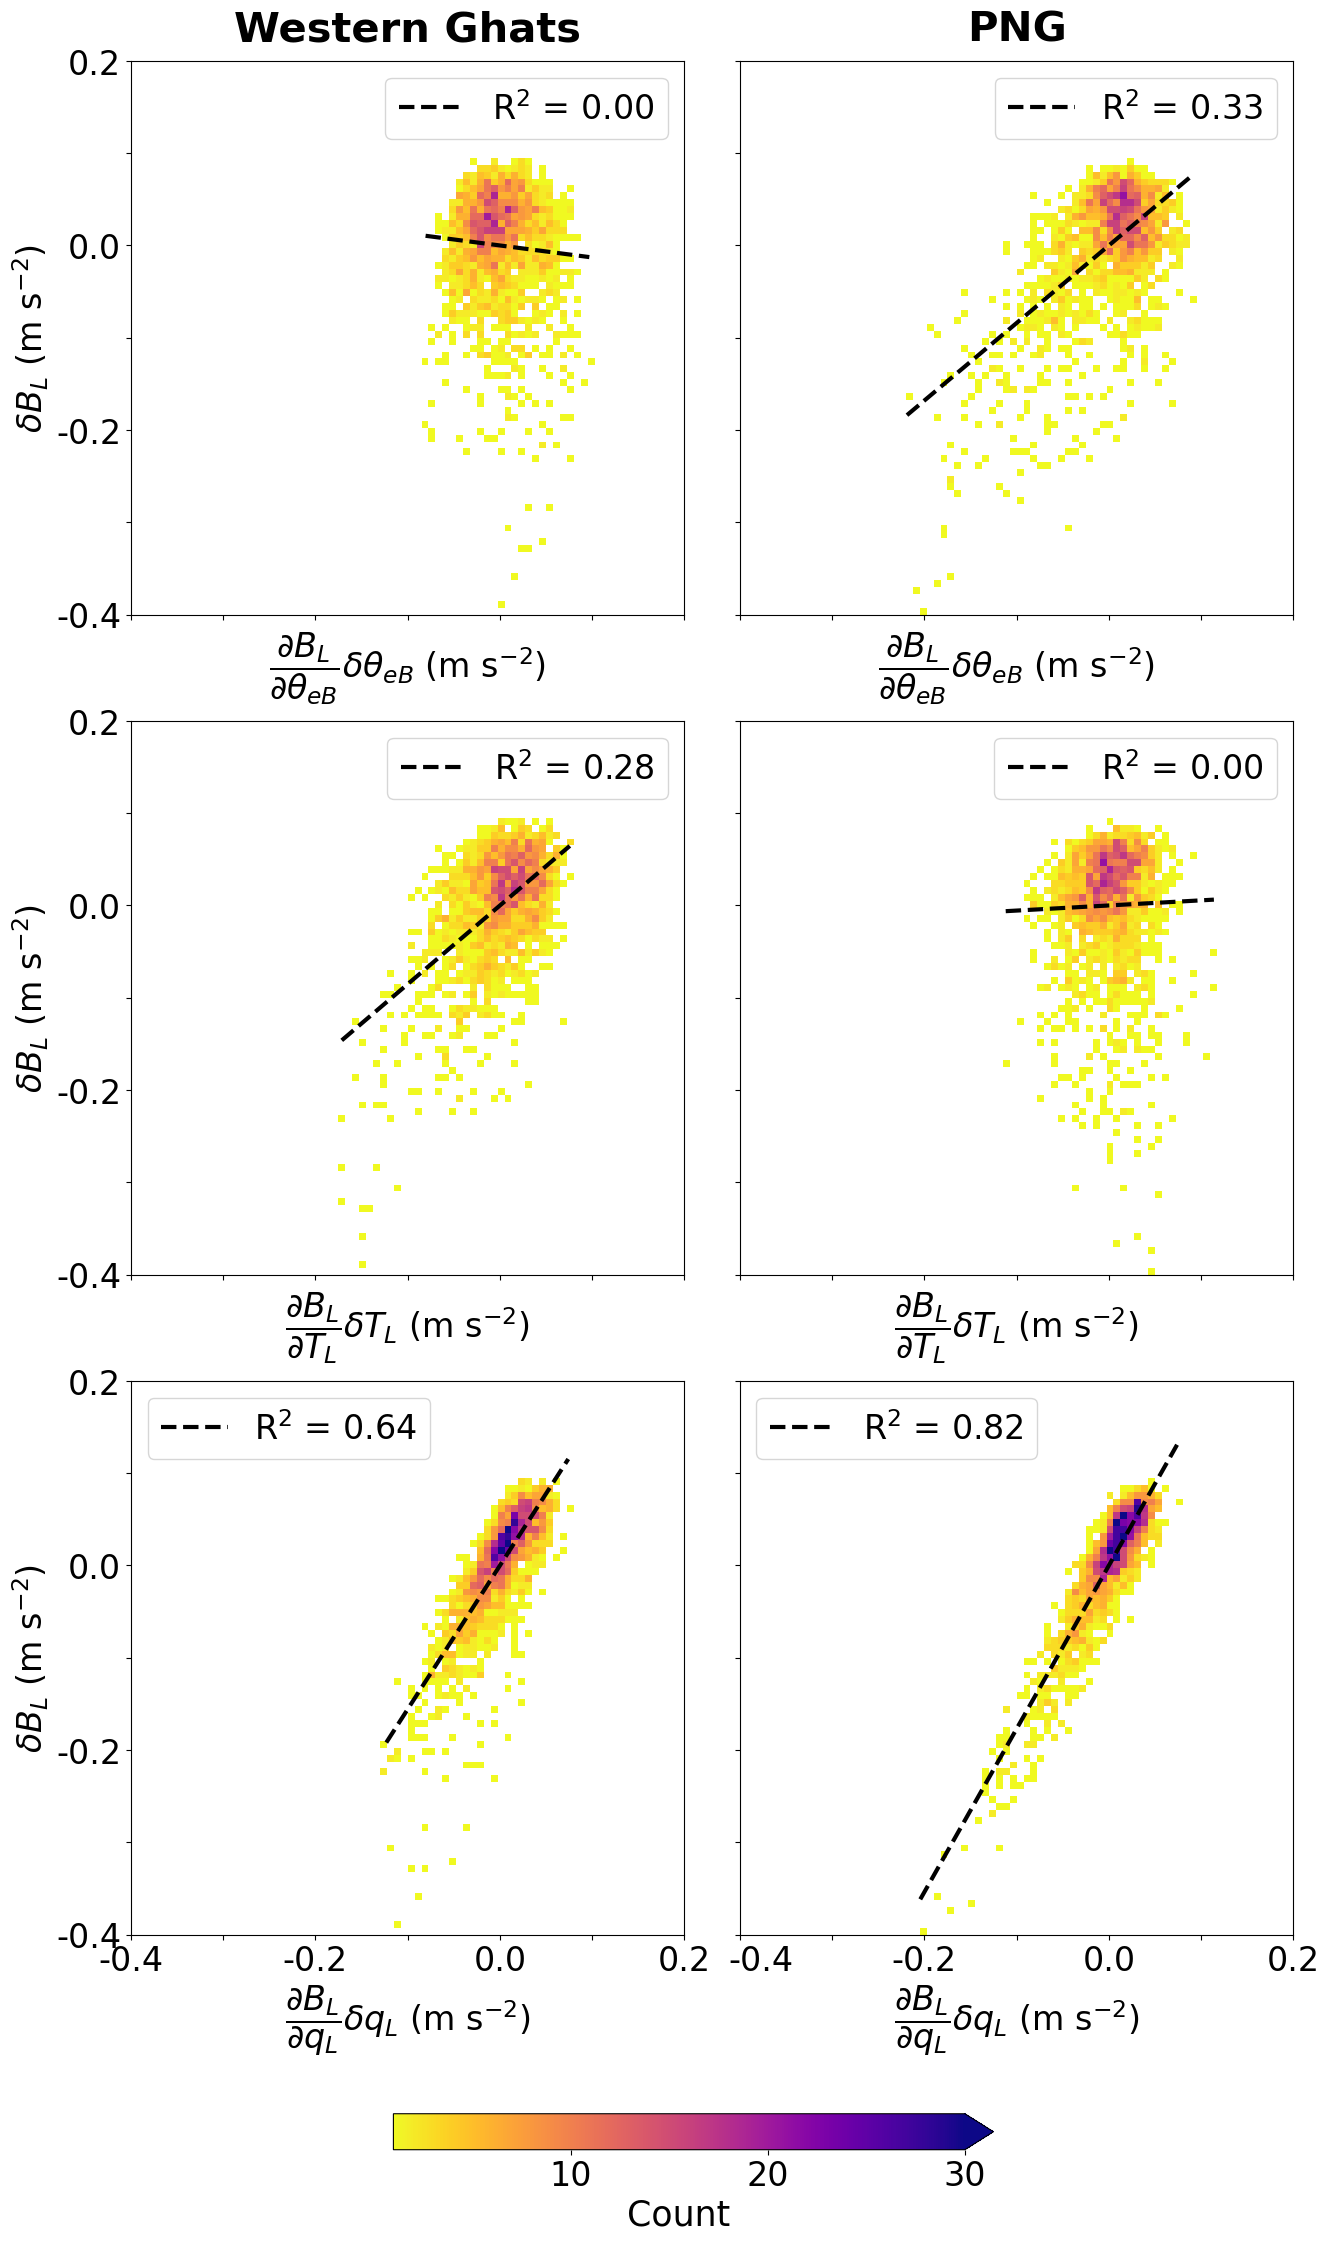

In [15]:
matplotlib.rcParams.update({'font.size':24})
fig = plt.figure(figsize=(15,24))

w0=0.1
gs1 = gridspec.GridSpec(3, 2,wspace=w0,hspace=0.1)
gs2 = gridspec.GridSpec(1, 1)

axss = [[fig.add_subplot(gs1[j,i]) for j in range(3)] for i in range(2)]
axcbar = fig.add_subplot(gs2[0,0])
# now the plots are on top of each other, we'll have to adjust their edges so that they won't overlap
gs1.update(bottom=0.08)
gs2.update(bottom=0.)
gs2.update(top=0.015)
gs2.update(left=0.3)
gs2.update(right=0.7)

for i,MR in enumerate((Ghats,Newbritain)):
    axs = axss[i]
    
    #Calculate B_L', T_L', q_L', thetaeB'
    deltaBl_above = MR.vars['BL_DAILY_ABOVE'] - MR.vars['BL_DAILY_ABOVE'].mean("time")
    predqL = dBLdqL*(MR.vars['QL_DAILY_ABOVE']-MR.vars['QL_DAILY_ABOVE'].mean('time'))*2.5e6/1004. 
    predTL = dBLdTL*(MR.vars['TL_DAILY_ABOVE']-MR.vars['TL_DAILY_ABOVE'].mean('time'))
    predeb = dBLdeb*(MR.vars['THETAEB_DAILY_ABOVE']-MR.vars['THETAEB_DAILY_ABOVE'].mean('time'))
    
    #perform linear regressions and plot 2d histograms
    for j,pred in enumerate((predeb,predTL,predqL)):
        reg = linregress(pred,deltaBl_above)
        bins_hist=np.linspace(-0.4,0.2,81)
        hs=axs[j].hist2d(pred,deltaBl_above, bins=[bins_hist,bins_hist], cmin=1,cmap=plt.cm.plasma_r, vmin=1,vmax=30)#, cmin=10)
        axs[j].plot(np.sort(pred),reg.intercept+reg.slope*np.sort(pred),color='k',linewidth=3,linestyle='--',label = 'R$^2$ = %.2f'%(reg.rvalue**2))
        axs[j].set_ylabel(r"$\delta B_L$ (m s$^{-2}$)")
        axs[j].legend()
        axs[j].set_xlim(-0.4,0.2)
        axs[j].set_ylim(-0.4,0.2)
        axs[j].set_aspect('equal')
        ticks = np.arange(-0.4,0.3,0.1)
        ticklabels=['-0.4','','-0.2','','0.0','','0.2']
        axs[j].set_xticks(ticks)
        axs[j].set_yticks(ticks)
        axs[j].set_xticklabels(ticklabels)
        axs[j].set_yticklabels(ticklabels)
        
        if i>0:
            axs[j].set_ylabel("")
            axs[j].set_yticklabels("")
        if j<2:
            axs[j].set_xlabel("")
            axs[j].set_xticklabels("")
        axs[j].set_aspect('equal')
    axs[0].set_xlabel(r"$\dfrac{\partial B_L}{\partial \theta_{eB}}\delta\theta_{eB}$ (m s$^{-2}$)")
    axs[1].set_xlabel(r"$\dfrac{\partial B_L}{\partial T_L}\delta T_L$ (m s$^{-2}$)")
    axs[2].set_xlabel(r"$\dfrac{\partial B_L}{\partial q_L}\delta q_L$ (m s$^{-2}$)")  
    axs[0].set_title(MR.Lname,weight='bold',size=30,pad=15)
axs[2].set_xticklabels([""]+ticklabels[1:])
axs[2].text(-0.02,-0.065,'-0.4',transform=axs[2].transAxes)

fig.colorbar(hs[-1], cax=axcbar,orientation='horizontal',extend='max')
axcbar.set_xlabel('Count',fontsize=25)
fig.savefig('figs/blpreds.eps',format='eps',bbox_inches='tight')
fig.savefig('figs/blpreds.png',dpi=70,bbox_inches='tight')


## Multiple linear regressions and R$^2$s

In [16]:
# For each set of predictor variables (thetaeB, TL, qL, (thetaeB,TL), (thetaeB,qL), (TL,qL)), 
# perform uni- and multi-variate linear regressions of B_L. Store the R2s.
nelems   = 6
nregions = len(MRs)
R2s = np.zeros((nregions,nelems))
for i,MR in enumerate(MRs):
    deltaBl_above = MR.vars['BL_DAILY_ABOVE'] - MR.vars['BL_DAILY_ABOVE'].mean("time")
    
    predqL = dBLdqL*(MR.vars['QL_DAILY_ABOVE']-MR.vars['QL_DAILY_ABOVE'].mean('time'))*2.5e6/1004. 
    predTL = dBLdTL*(MR.vars['TL_DAILY_ABOVE']-MR.vars['TL_DAILY_ABOVE'].mean('time'))
    predeb = dBLdeb*(MR.vars['THETAEB_DAILY_ABOVE']-MR.vars['THETAEB_DAILY_ABOVE'].mean('time'))
    for j,pred in enumerate((predeb,predTL,predqL)):
        X = pred.data.reshape(-1, 1)
        Y = deltaBl_above
        R2 = LinearRegression().fit(X,Y).score(X,Y)
        R2s[i,j] = R2
    for j,predcouple in enumerate(((predeb,predTL),(predeb,predqL),(predTL,predqL))):
        X = np.vstack(predcouple).transpose()
        Y = deltaBl_above
        R2 = LinearRegression().fit(X,Y).score(X,Y)
        R2s[i,j+3] = R2

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


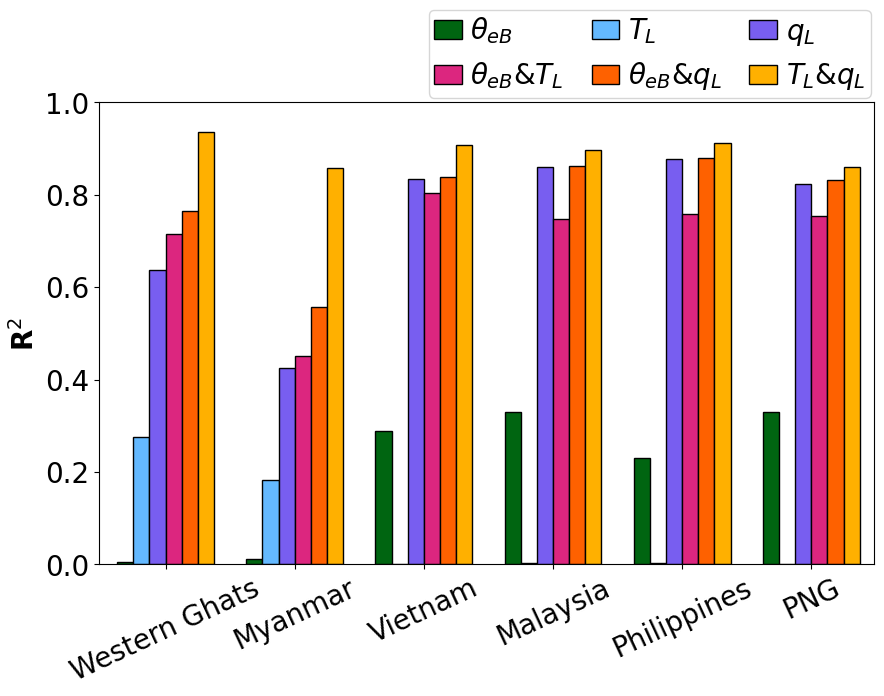

In [17]:
matplotlib.rcParams.update({'font.size':20})
# set width of bars
nelems   = 6
nregions = len(MRs)
barWidth = 1/(nelems+2)
fig,ax = plt.subplots(figsize =(10, 6))

colors = ['#006511','#64B9FF','#785EF0','#DC267F','#FE6100','#FFB000']
labels = [r"$\theta_{eB}$",r"$T_L$",r"$q_L$",r"$\theta_{eB}$&$T_L$",r"$\theta_{eB}$&$q_L$",r"$T_L$&$q_L$"]
# Set position of bar on X axis & plot bar
brs = np.arange(nregions)
for i in range(nelems):
    plt.bar(brs + i*barWidth, R2s[:,i], color =colors[i], width = barWidth,
            edgecolor ='k', label = labels[i])    

# Adding Xticks
plt.ylabel(r'R$^2$', fontweight ='bold', fontsize = 20)
plt.xticks([r + (nelems-1)/2*barWidth for r in range(nregions)],[MR.Lname for MR in MRs],rotation=25)

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,3,1,4,2,5]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order],handlelength=1,borderpad=0.2,handletextpad=0.3,ncol=3,columnspacing=1,loc=(0.425,1.01))

plt.ylim(0,1.)
plt.xlim(-0.2,5.8)
plt.yticks(np.arange(0,1.1,0.2));
fig.savefig('figs/r2s.eps',format='eps',bbox_inches='tight')
fig.savefig('figs/r2s.png',dpi=70,bbox_inches='tight')

# Correlations

In [18]:
for i,MR in enumerate(MRs):
    pred = MR.vars['THETAEB_DAILY_ABOVE']
    var = MR.vars['SST_DAILY_ABOVE']
    print("{:<12}: {:>.2f}".format(MR.name,np.corrcoef(pred,var)[0,1]))

ghats       : 0.80
myanmar     : 0.53
vietnam     : 0.61
malaysia    : 0.69
philippines : 0.56
newbritain  : 0.60


In [19]:
for i,MR in enumerate(MRs):
    pred = MR.vars['THETAEB_DAILY_ABOVE']
    var = MR.vars['IMERG_DAILY_ABOVE']
    print("{:<12}: {:>.2f}".format(MR.name,np.corrcoef(pred,var)[0,1]))

ghats       : 0.19
myanmar     : 0.16
vietnam     : 0.23
malaysia    : 0.17
philippines : 0.12
newbritain  : 0.15


In [20]:
for i,MR in enumerate(MRs):
    pred = MR.vars['QL_DAILY_ABOVE']
    var = MR.vars['IMERG_DAILY_ABOVE']
    print("{:<12}: {:>.2f}".format(MR.name,np.corrcoef(pred,var)[0,1]))

ghats       : 0.56
myanmar     : 0.30
vietnam     : 0.53
malaysia    : 0.51
philippines : 0.50
newbritain  : 0.51


In [21]:
for i,MR in enumerate(MRs):
    pred = MR.vars['TL_DAILY_ABOVE']
    var = MR.vars['IMERG_DAILY_ABOVE']
    print("{:<12}: {:>.2f}".format(MR.name,np.corrcoef(pred,var)[0,1]))

ghats       : -0.15
myanmar     : -0.18
vietnam     : 0.03
malaysia    : -0.18
philippines : -0.06
newbritain  : -0.15


# Fig - wind regressed on $T_L$

In [22]:
import matplotlib.colors as colors
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap
new_cmap = truncate_colormap(plt.cm.plasma,0.2,1) # Exclude the dark colors that aren't very visible

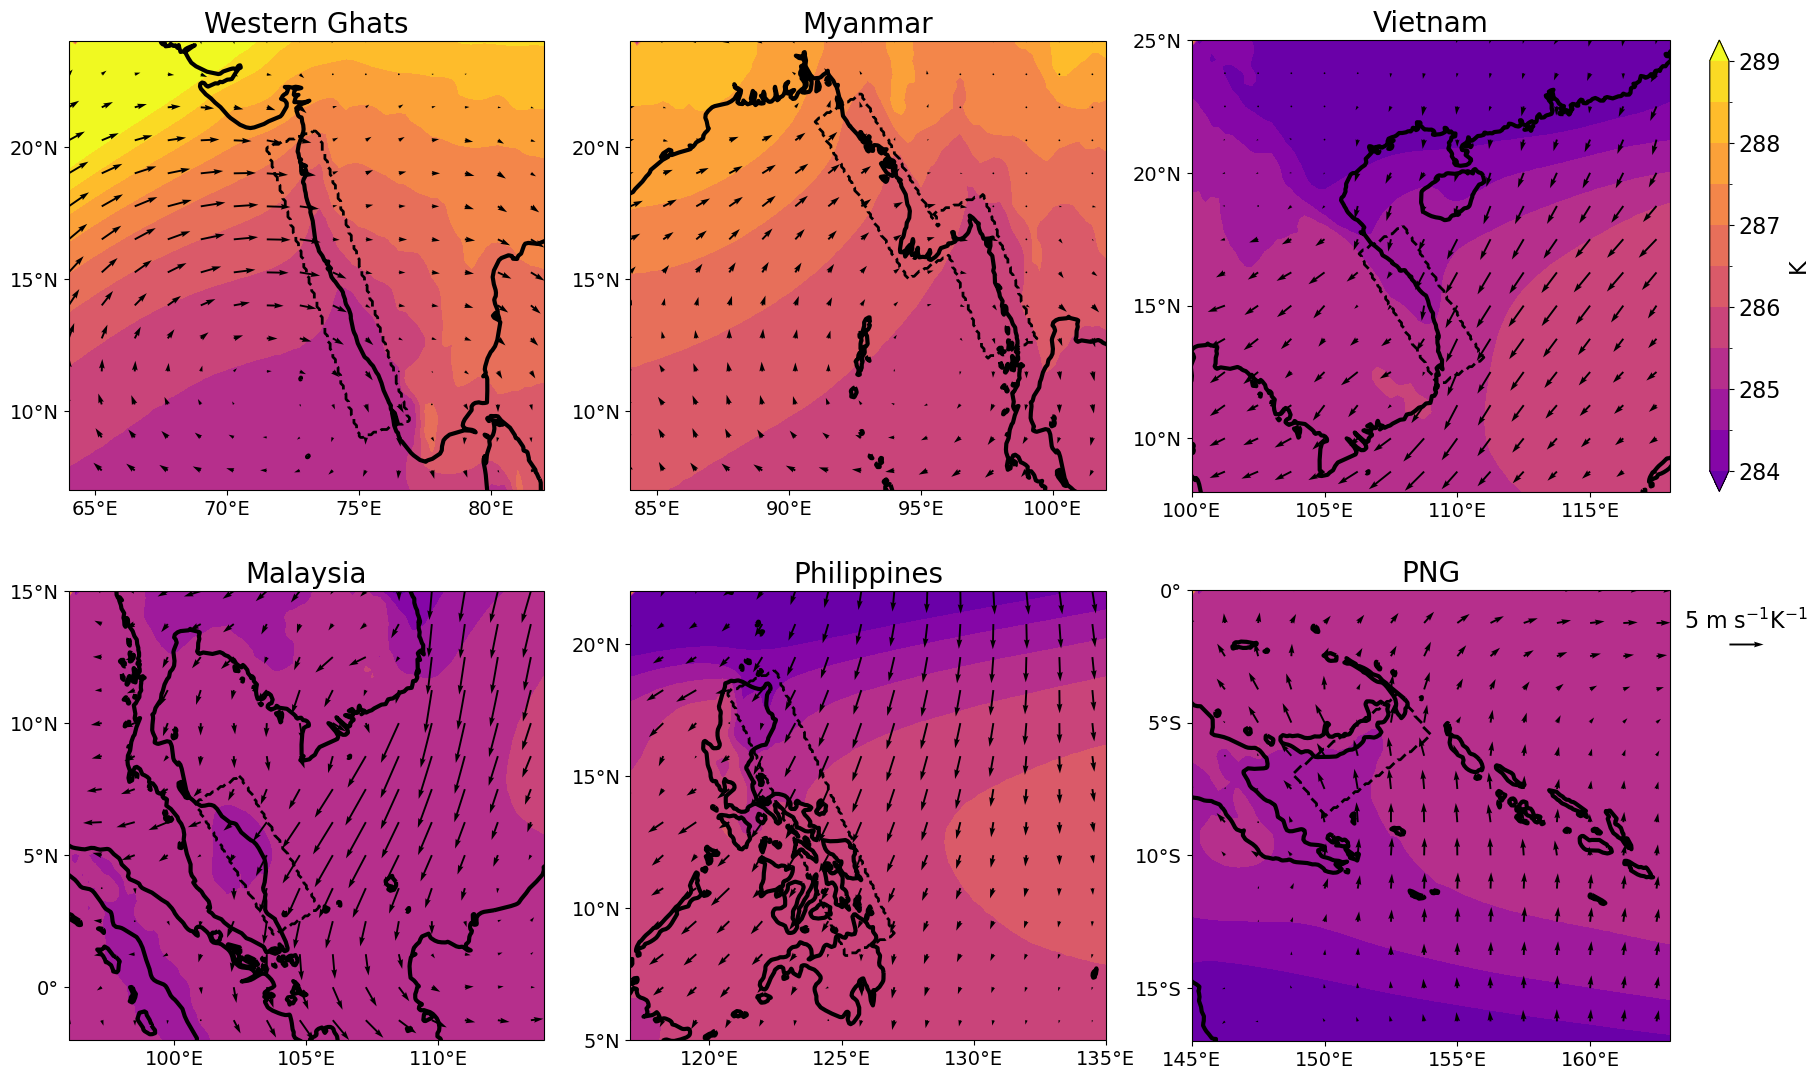

In [23]:
matplotlib.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(18,11))
spec = gridspec.GridSpec(ncols=3, nrows=2, width_ratios= [1,1,1.13],height_ratios=[1,1],figure=fig)
axs=[]
cs=[]
for i,MR in enumerate(MRs):
    ax = fig.add_subplot(spec[i//3,i%3],projection= ccrs.PlateCarree())
    axs.append(ax)
    ax=axs[i]
    ax.set_anchor('W')

    pred = -MR.vars['TL_DAILY_ABOVE']
    u = MR.vars['UBL_DAILY'];v = MR.vars['VBL_DAILY']
    
    # Plot background tL
    tmean = MR.vars['TL_DAILY'].mean('time')
    tmean[0,0]=290 # ensure all plots use same colormap
    tmean[0,1]=283 # ensure all plots use same colormap
    c = tmean.plot.contourf(ax=ax,add_colorbar=False,levels=np.linspace(284,289,11),cmap=new_cmap)
    
    # Regress boundary-layer wind on tL time series and plot
    ureg = linregress_xr(pred,u)
    vreg = linregress_xr(pred,v)
    fdrfact = fdr_xr_2d(ureg.pvalue,0.01) + fdr_xr_2d(vreg.pvalue,0.01) >0
    u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    Q = add_wind(ax,u,v,width=0.004,scale=70,key=False)

    # Plot rain band outline
    MR.mask_above_gpm.plot.contour(ax=ax,levels=[0.5],linestyles=['--'],linewidths=[2],colors=['k'])

    ax.coastlines(linewidth=3)
    ax.set_title(MR.Lname)
    add_latlon(ax,MR.box,ftz=14)
    
    ax.set_title(MR.Lname,fontsize=20)

# Colorbar
pad=.4;size="4%"
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(c, cax=cax,label=r'K')

divider2 = make_axes_locatable(axs[5])
cax2 = divider2.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
cax2.remove()

# Quiver key (reference wind arrow)
qk = axs[5].quiverkey(Q, 1.16, 0.88, 5, r'5 m s$^{-1}$K$^{-1}$', labelpos='N',
                   coordinates='axes',color='k')

    
fig.tight_layout(pad=0.01,h_pad=0.0,w_pad=0.0)
fig.savefig('figs/TL.eps',format='eps',bbox_inches='tight')
fig.savefig('figs/TL.png',dpi=70,bbox_inches='tight')



# Fig - wind regressed onto $q_L$

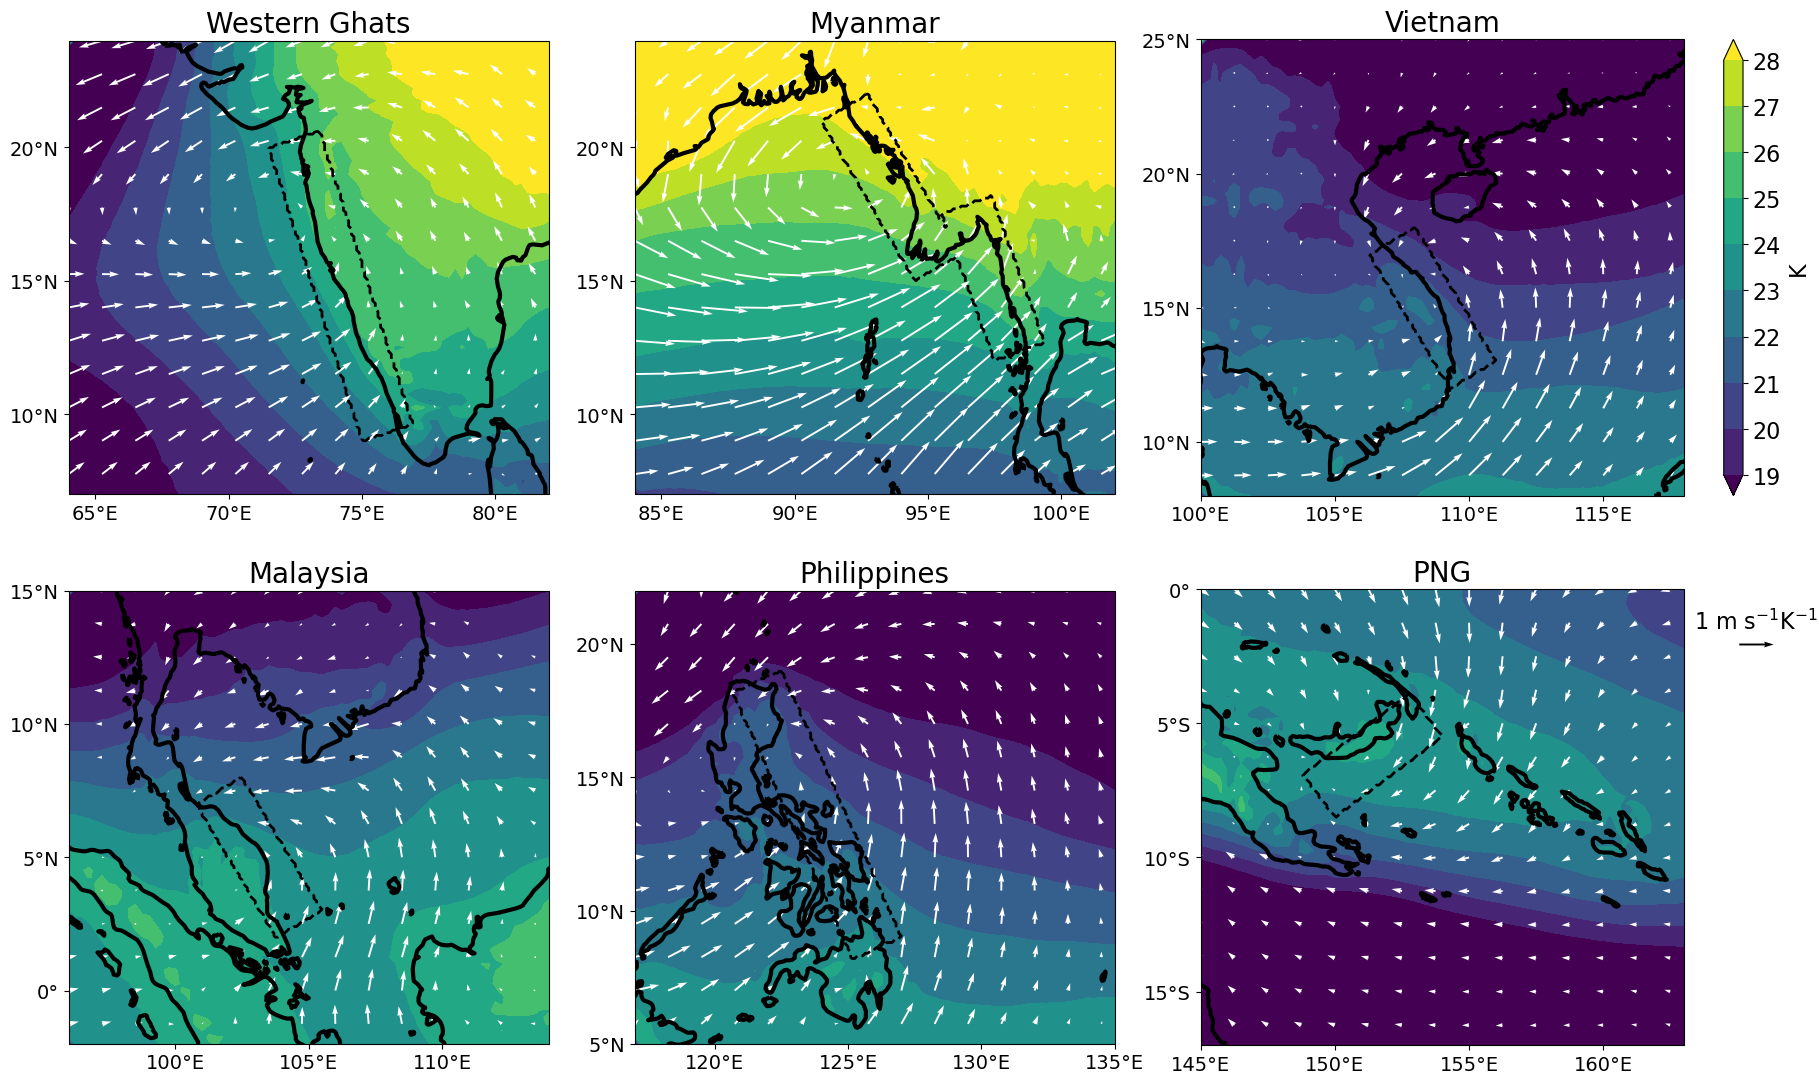

In [24]:
matplotlib.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(18,11))
spec = gridspec.GridSpec(ncols=3, nrows=2, width_ratios= [1,1,1.13],height_ratios=[1,1],figure=fig)
axs=[]
cs=[]
for i,MR in enumerate(MRs):
    ax = fig.add_subplot(spec[i//3,i%3],projection= ccrs.PlateCarree())
    axs.append(ax)
    ax=axs[i]
    ax.set_anchor('W')

    pred = MR.vars['QL_DAILY_ABOVE']*2.5e3
    u = MR.vars['UBL_DAILY'];v = MR.vars['VBL_DAILY']
    
    # Plot background tL
    qmean = (MR.vars['QL_DAILY'].mean('time')*2.5e3)
    qmean[0,0] = 29.   # ensure all plots use same colormap
    qmean[-1,0] = 18.  # ensure all plots use same colormap
    c = qmean.plot.contourf(ax=ax,add_colorbar=False,levels= np.arange(19,29.,1.),cmap=plt.cm.viridis)
    
    # Regress boundary-layer wind on tL time series and plot
    ureg = linregress_xr(pred,u)
    vreg = linregress_xr(pred,v)
    fdrfact = fdr_xr_2d(ureg.pvalue,0.01) + fdr_xr_2d(vreg.pvalue,0.01) >0
    u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    Q = add_wind(ax,u,v,color='w',width=0.004,scale=14,key=False)

    # Plot rain band outline
    MR.mask_above_gpm.plot.contour(ax=ax,levels=[0.5],linestyles=['--'],linewidths=[2],colors=['k'])

    ax.coastlines(linewidth=3)
    ax.set_title(MR.Lname)
    add_latlon(ax,MR.box,ftz=14)
    
    ax.set_title(MR.Lname,fontsize=20)

# Colorbar
pad=.4;size="4%"
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(c, cax=cax,label=r'K')#,ticks=np.arange(10,35,5))

divider2 = make_axes_locatable(axs[5])
cax2 = divider2.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
cax2.remove()

# Quiver key (reference wind arrow)
qk = axs[5].quiverkey(Q, 1.15, 0.88, 1, r'1 m s$^{-1}$K$^{-1}$', labelpos='N',
                   coordinates='axes',color='k')

    
fig.tight_layout(pad=0.01,h_pad=0.0,w_pad=0.0)
fig.savefig('figs/qL.eps',format='eps',bbox_inches='tight')
fig.savefig('figs/qL.png',dpi=70,bbox_inches='tight')




# Fig - precip & wind regressed on precip

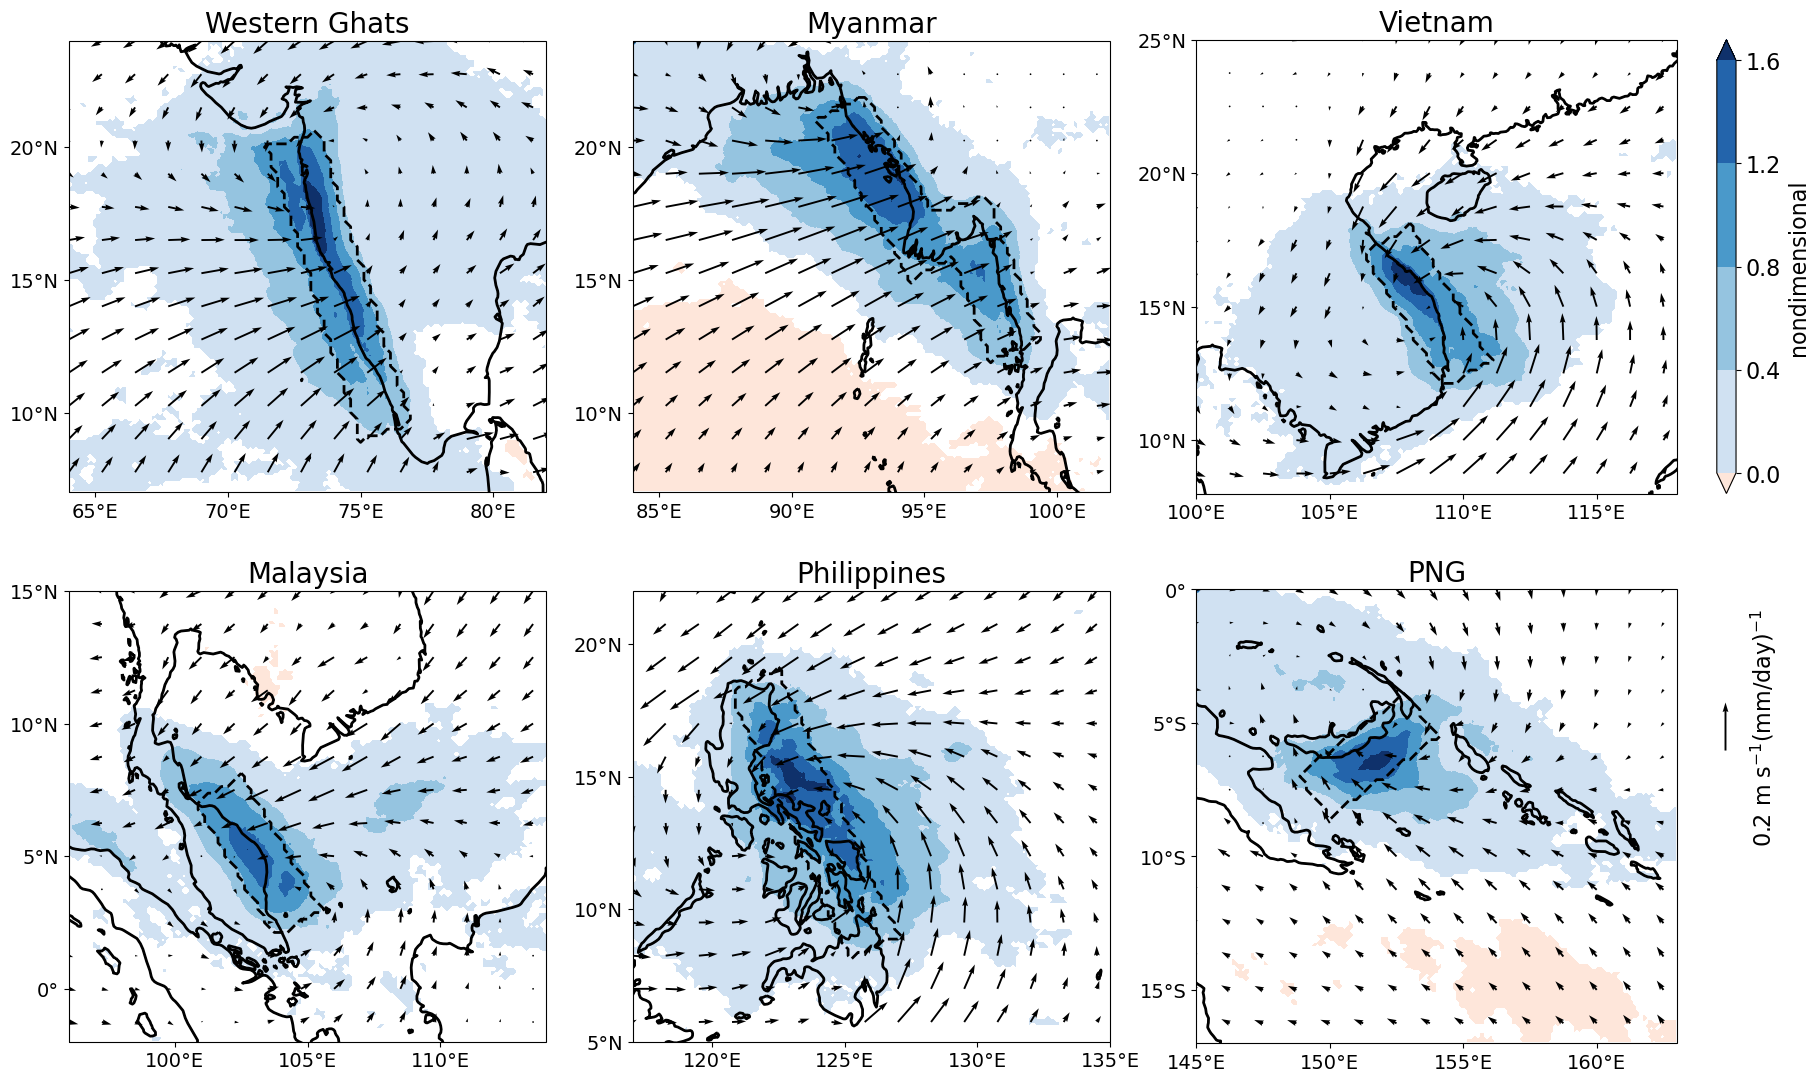

In [25]:
matplotlib.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(18,11))
spec = gridspec.GridSpec(ncols=3, nrows=2, width_ratios= [1,1,1.13],height_ratios=[1,1],figure=fig)
axs=[]
cs=[]
for i,MR in enumerate(MRs):
    ax = fig.add_subplot(spec[i//3,i%3],projection= ccrs.PlateCarree())
    axs.append(ax)
    ax=axs[i]
    ax.set_anchor('W')

    pred = MR.vars['IMERG_DAILY_ABOVE']
    u = MR.vars['UBL_DAILY'];v = MR.vars['VBL_DAILY']
    
    # regress precip onto precip index in rain band; plot
    prreg = linregress_xr(pred,MR.vars['IMERG_DAILY'].transpose('time','latitude','longitude'))
    prregpr = (prreg.slope) / fdr_xr_2d(prreg.pvalue,0.01)
    prregpr[0,0] = 1.7
    prregpr[-1,0] = -0.1
    c = prregpr.plot.contourf(ax=ax,add_colorbar=False,levels= np.arange(0,1.7,0.4),colors=('#FEE6DA','#D0E1F2','#95C4E0','#4A99CA','#2364AB','#0F316B'))
    
    # regress wind onto precip index in rain band; plot
    ureg = linregress_xr(pred,u)
    vreg = linregress_xr(pred,v)
    fdrfact = fdr_xr_2d(ureg.pvalue,0.01) + fdr_xr_2d(vreg.pvalue,0.01) >0
    u = ureg.slope /fdrfact;v=vreg.slope /fdrfact
    MR.uregpr = u
    MR.vregpr = v
    Q = add_wind(ax,MR.uregpr,MR.vregpr,color='k',width=0.004,scale=2,key=False)

    # Rain band outline
    MR.mask_above_era5.plot.contour(ax=ax,levels=[0.5],linestyles=['--'],linewidths=[2],colors=['k'])

    ax.coastlines(linewidth=2)
    ax.set_title(MR.Lname)
    add_latlon(ax,MR.box,ftz=14)
    
    ax.set_title(MR.Lname,fontsize=20)

# Colorbar
pad=.4;size="4%"
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(c, cax=cax,label=r'nondimensional')#,ticks=np.arange(10,35,5))

divider2 = make_axes_locatable(axs[5])
cax2 = divider2.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
cax2.remove()

# Quiver key (reference wind arrow)
qk = axs[5].quiverkey(Q, 1.1, 0.7, 0.2,label='', labelpos='N',
                   coordinates='axes',color='k',angle=90)
axs[5].text(1.15, 0.45, r'0.2 m s$^{-1}$(mm/day)$^{-1}$',transform=axs[5].transAxes,color='k',rotation=90)
    
fig.tight_layout(pad=0.01,h_pad=0.0,w_pad=0.0)
fig.savefig('figs/prregs.eps',format='eps',bbox_inches='tight')
fig.savefig('figs/prregs.png',dpi=70,bbox_inches='tight')


# Fig - BL spatial maps

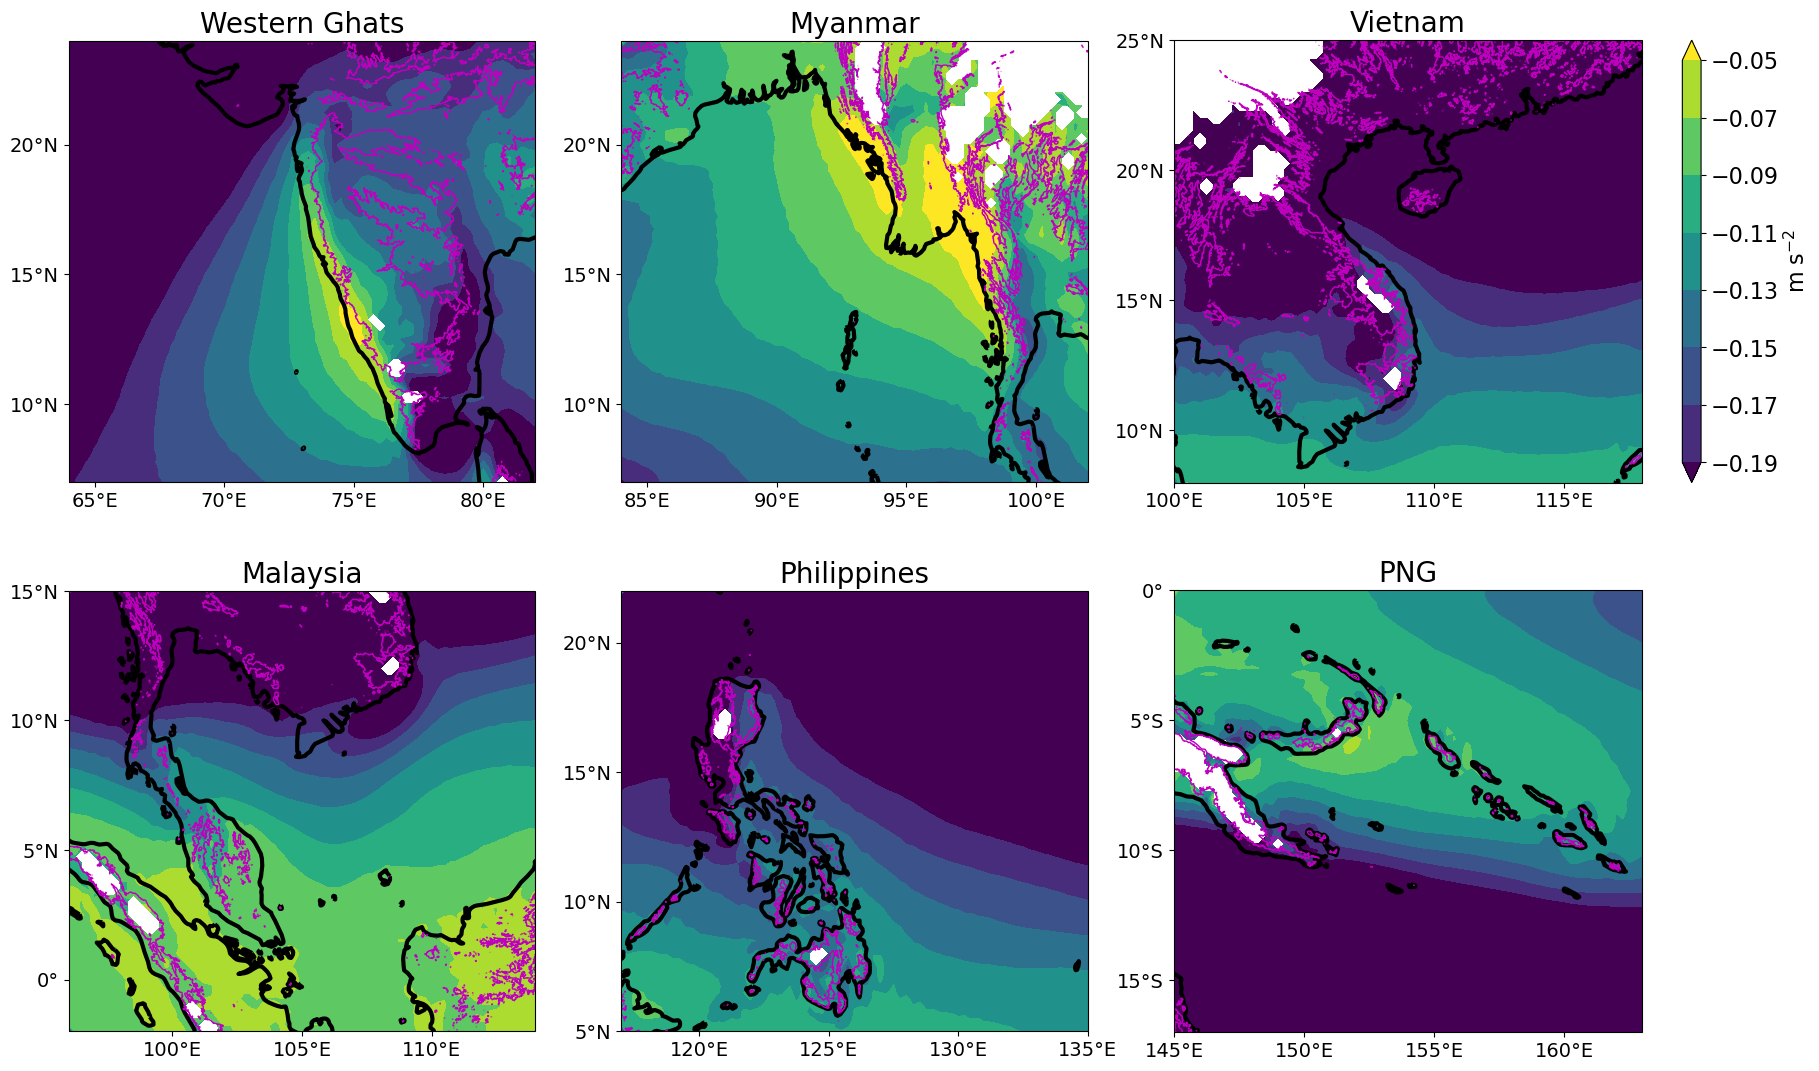

In [26]:
matplotlib.rcParams.update({'font.size': 16})

fig = plt.figure(figsize=(18,11))
spec = gridspec.GridSpec(ncols=3, nrows=2, width_ratios= [1,1,1.13],height_ratios=[1,1],figure=fig)
axs=[]
cs=[]
for i,MR in enumerate(MRs):
    ax = fig.add_subplot(spec[i//3,i%3],projection= ccrs.PlateCarree())
    axs.append(ax)
    ax=axs[i]
    ax.set_anchor('W')

    # Plot time-mean BL; ensure all plots use same colorbar
    BL = (MR.vars['BL_DAILY'].mean('time'))
    BL[0,0] = -0.04
    BL[-1,0] = -0.2
    c = BL.plot.contourf(ax=ax,add_colorbar=False,transform=ccrs.PlateCarree(),levels=np.arange(-0.19,-0.04,0.02))
    sel_box(topo_hires,MR.box).plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[1.],colors=['m'])
    
    ax.coastlines(linewidth=3)
    ax.set_title(MR.Lname)
    add_latlon(ax,MR.box,ftz=14)

    
    ax.set_title(MR.Lname,fontsize=20)

# Colorbar
pad=.4;size="4%"
divider = make_axes_locatable(axs[2])
cax = divider.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
plt.colorbar(c, cax=cax,label=r'm s$^{-2}$')

divider2 = make_axes_locatable(axs[5])
cax2 = divider2.append_axes("right", size=size, pad=pad,axes_class=plt.Axes)
cax2.remove()

fig.tight_layout(pad=0.01,h_pad=0.0,w_pad=0.0)
fig.savefig('figs/BLmaps.eps',format='eps',bbox_inches='tight')
fig.savefig('figs/BLmaps.png',dpi=70,bbox_inches='tight')


# Fig - Ghats precipitation models

In [6]:
Ghats      .U0 = 10  ; Ghats      .V0 =  1  ; Ghats      .P0 = 3
Myanmar    .U0 =  8  ; Myanmar    .V0 =  8  ; Myanmar    .P0 = 6
Vietnam    .U0 = -7  ; Vietnam    .V0 = -5  ; Vietnam    .P0 = 4
Malaysia   .U0 = -7  ; Malaysia   .V0 = -5  ; Malaysia   .P0 = 10
Philippines.U0 = -8.5; Philippines.V0 = -3  ; Philippines.P0 = 4
Newbritain .U0 = -7.5; Newbritain .V0 =  5.5; Newbritain .P0 = 3


In [7]:
Ghats      .angle = 80 ; Ghats      .width = 0.2
Myanmar    .angle = 50 ; Myanmar    .width = 0.23
Vietnam    .angle = 240; Vietnam    .width = 0.1
Malaysia   .angle = 240; Malaysia   .width = 0.1
Philippines.angle = 250; Philippines.width = 0.25
Newbritain .angle = 310; Newbritain .width = 0.1

In [8]:
%%time  # Takes quite a while; FFTs over large domains as the topography is high-resolution. Can coarsen topography if needed
for MR in MRs:
    MR.vars['LINEAR_PR']  = p_lineartheory_region(MR, topo='ETOPO', pad='big', N=0.01                 )
    MR.vars['SMITH_PR']   = p_smiththeory_region (MR, topo='ETOPO', pad='big', N=0.01, gamma_m=4e-3)
    MR.vars['VIWVE'] = MR.vars['VIWVE_DAILY'].mean('time')
    MR.vars['VIWVN'] = MR.vars['VIWVN_DAILY'].mean('time')
    MR.vars['UPSLOPE_PR'] = p_upslope_region(MR,topo='ERA5', version='IVT')

CPU times: user 1min 14s, sys: 41.8 s, total: 1min 56s
Wall time: 1min 56s


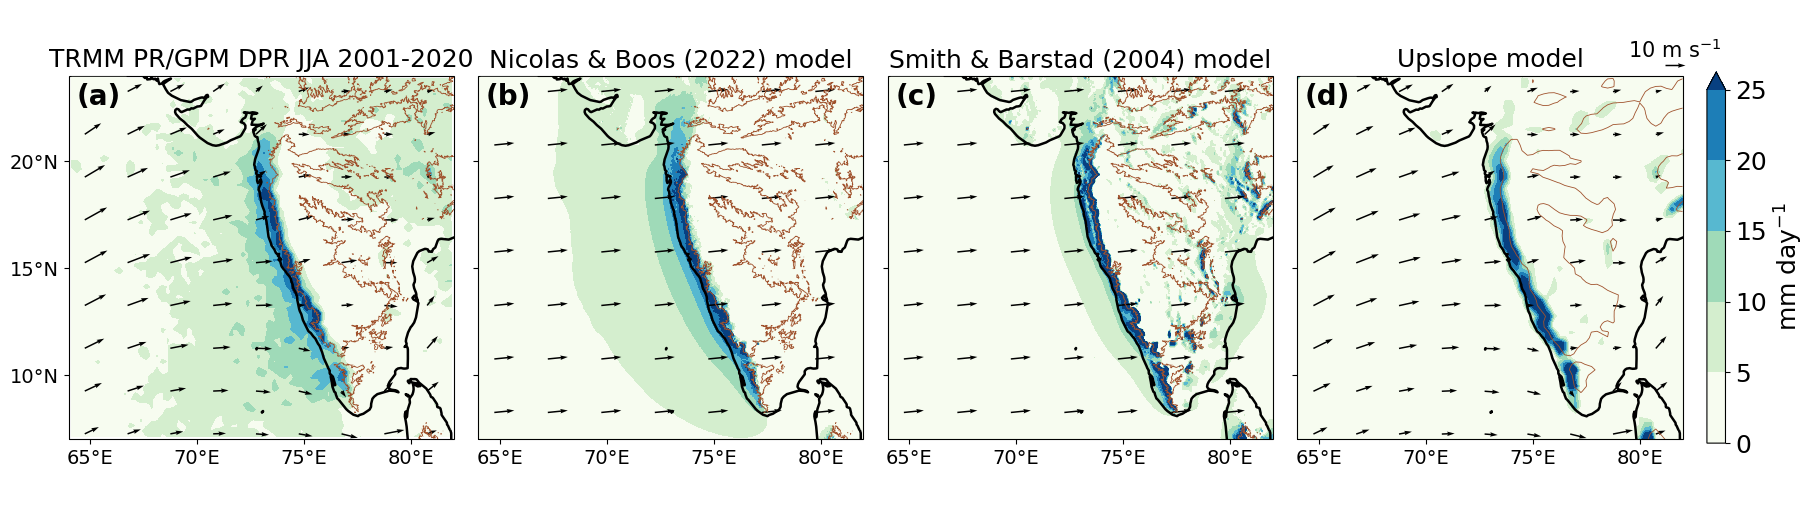

In [9]:
matplotlib.rcParams.update({'font.size': 18})
MR=Ghats
fig = plt.figure(figsize=(18,5))
spec = gridspec.GridSpec(ncols=5, nrows=1, width_ratios= [1,1,1,1,0.05],figure=fig)
titles = ("TRMM PR/GPM DPR JJA 2001-2020","Nicolas & Boos (2022) model","Smith & Barstad (2004) model","Upslope model")
letters = ['a','b','c','d']
for i,pr in enumerate((MR.vars['MERGED_RADAR_PR'],MR.vars['LINEAR_PR'],MR.vars['SMITH_PR'],0.25*MR.vars['UPSLOPE_PR'])):
    pr[0,0]=26.
    ax = fig.add_subplot(spec[i],projection= ccrs.PlateCarree())
    
    ### PRECIP ###
    c = pr.plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,30.,5.),cmap=plt.cm.GnBu,add_colorbar=False)
    
    ### QUIVERS ###
    u=MR.vars['VAR_100U']
    v=MR.vars['VAR_100V']
    X = u.latitude.expand_dims({"longitude":u.longitude}).transpose()
    Y = u.longitude.expand_dims({"latitude":u.latitude})
    n=len(u.latitude)//8; m=n
    ibeg=3;iend=-1
    sc=0.5;w=1.5
    if i==0 or i==3:
        Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(u)[ibeg:iend:n,ibeg:iend:n], np.array(v)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=sc,width=w,units='dots')
    else:
        n = int(n*1.25)
        m=n    
        Q=ax.quiver(np.array(Y)[ibeg:iend:n,ibeg:iend:n],np.array(X)[ibeg:iend:n,ibeg:iend:n], np.array(MR.U0*u**0)[ibeg:iend:n,ibeg:iend:n], np.array(MR.V0*v**0)[ibeg:iend:n,ibeg:iend:n],color="k",transform=ccrs.PlateCarree(),scale=sc,width=w,units='dots')

    ### COSMETICS ###
    ax.coastlines(linewidth=1.8)
    if i<3:
        MR.vars['Z_HR'].plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[0.6],colors=['sienna'])
    else:
        MR.vars['Z'].plot.contour(ax=ax,transform=ccrs.PlateCarree(),levels=[500.],linewidths=[0.6],colors=['sienna'])
    add_latlon(ax,MR.box,ftz=14)
    if i>0:
        ax.set_yticklabels("")
    ax.set_title(titles[i],fontsize=18)
    ax.text(0.02, 0.92,'(%s)'%letters[i], transform=ax.transAxes,color='k',weight='bold',fontsize=20,backgroundcolor='#F7FCF0')

ax.quiverkey(Q, 0.98,1.03, 10, label=r'10 m s$^{-1}$', labelpos='N',
               coordinates='axes',color='k',labelsep=0.03,fontproperties={'size':15})
  
# Colorbar
axcbar = fig.add_subplot(spec[-1])
axcbar.axis('off')
fig.colorbar(c,ax=axcbar,fraction=1,shrink=0.75,orientation='vertical',label=r'mm day$^{-1}$')   
fig.tight_layout(pad=0.1,w_pad=0.7)

fig.savefig('figs/ghatsmaps.eps',format='eps',bbox_inches='tight')
fig.savefig('figs/ghatsmaps.png',dpi=70,bbox_inches='tight')



# Fig - Observed & modeled precipitation cross sections

Load the first three cells of the previous section before proceeding.

In [10]:
def rot_slice(var,angle,width):
    # Take a cross-sectional average along a slanted path
    rvar = rotate_var(var.transpose('latitude','longitude'),angle)
    n,m = rvar.shape
    bounds = int(m*(0.5-width)), int(m*(0.5+width))
    return rvar.isel(y=slice(*bounds)).mean('y')
from scipy.ndimage import gaussian_filter
def filtr(da):
    sigma=4
    return da**0*gaussian_filter(da,sigma)

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


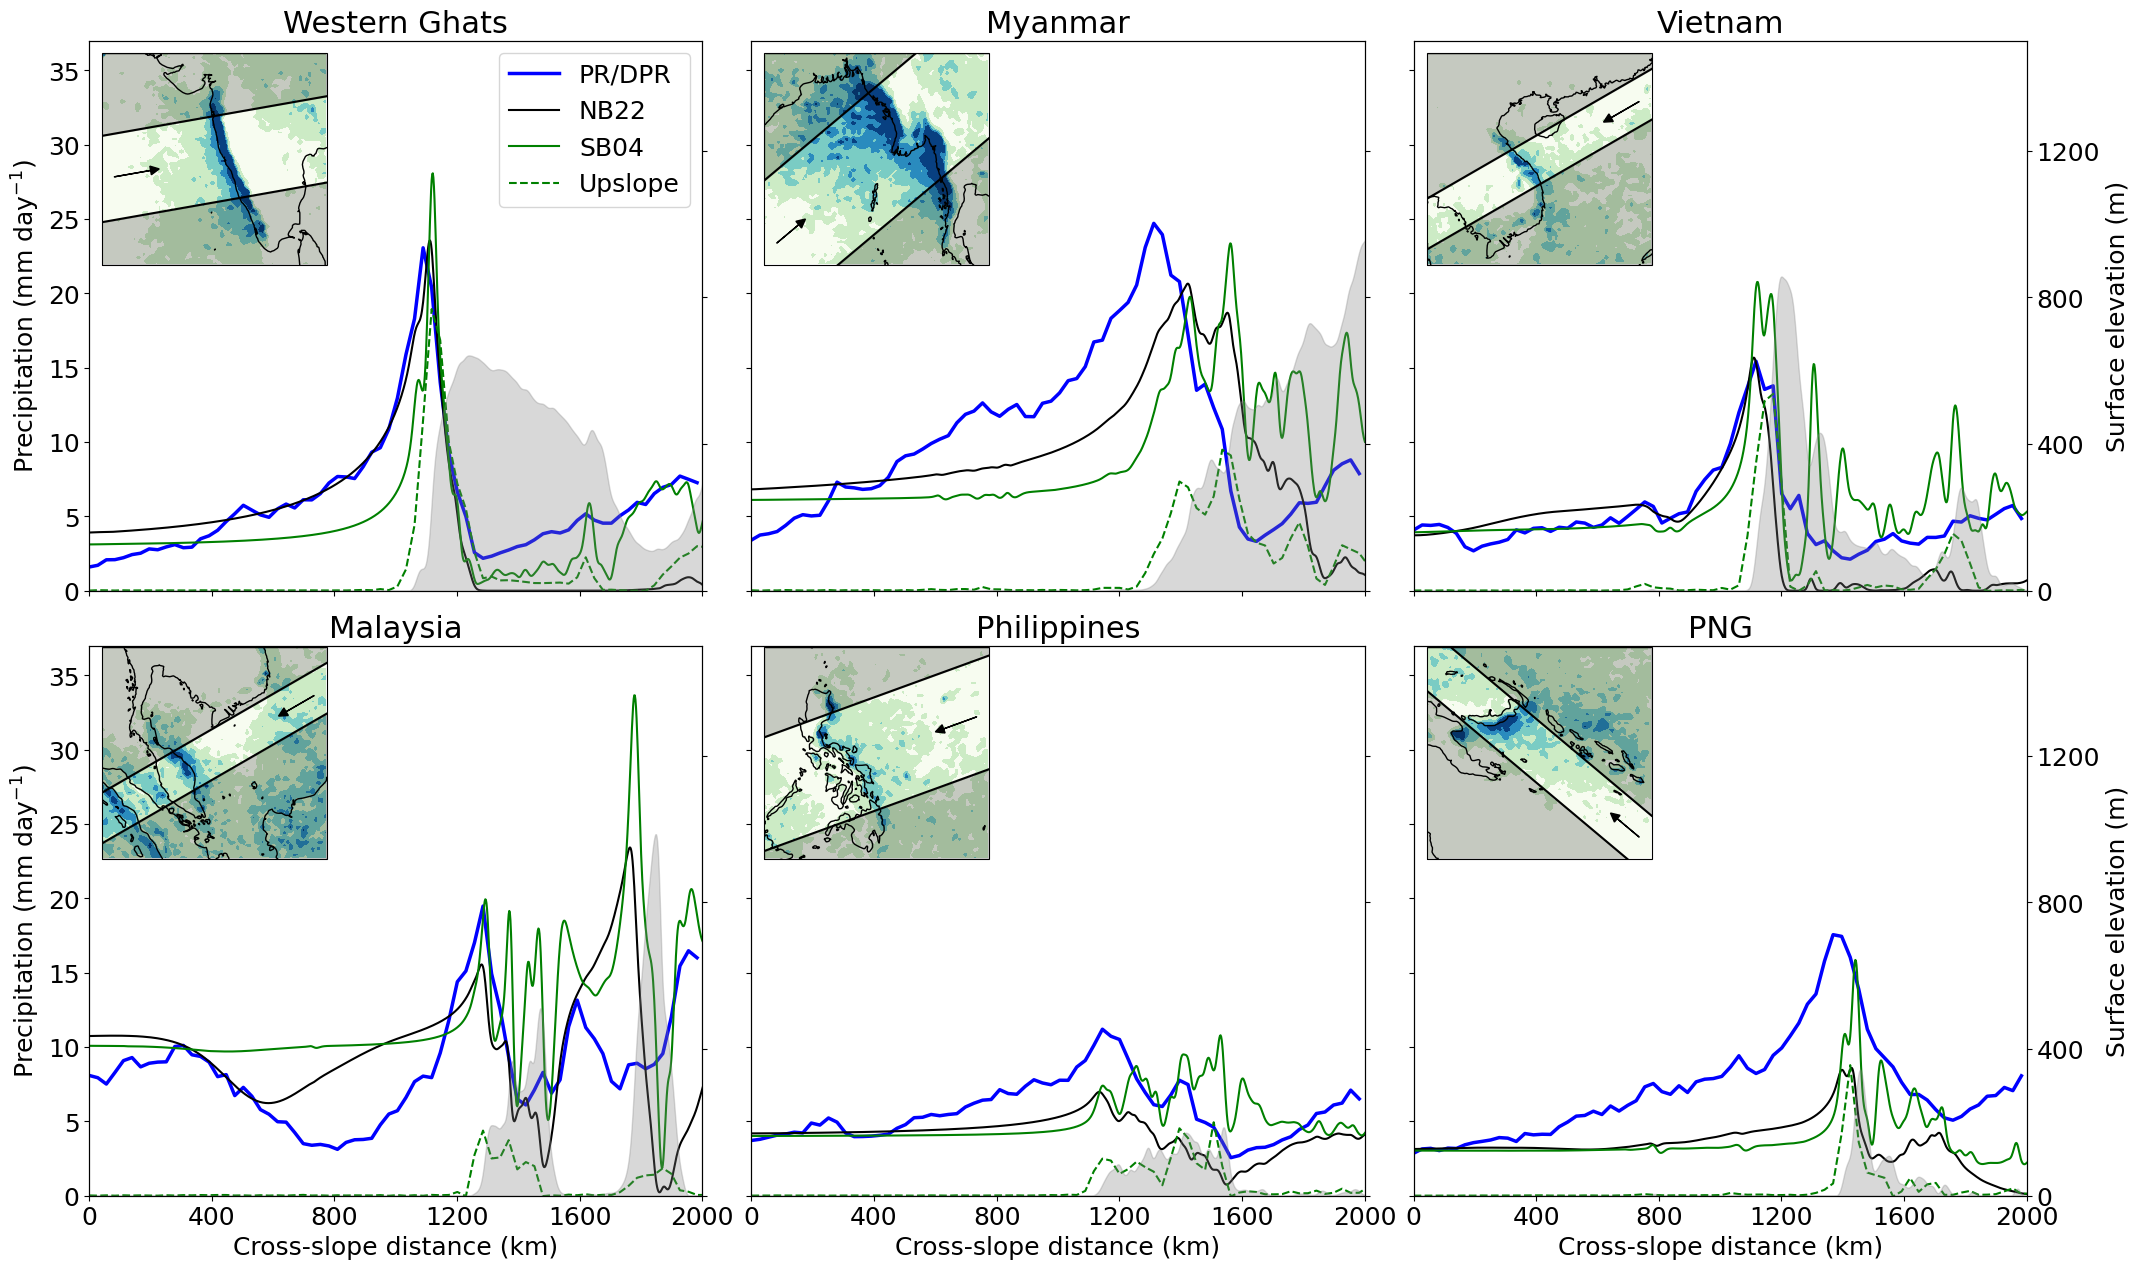

In [12]:
matplotlib.rcParams.update({'font.size': 18})
fig = plt.figure(figsize=(25,15))
gs1 = gridspec.GridSpec(2,3,wspace=0.08,hspace=0.1)
axs = [fig.add_subplot(gs1[i,j]) for i in range(2) for j in range(3)]

# add them 1 by 1 ..
h=0.15;w=0.09
top_0 = 0.876; bot_0 = top_0-h; 
top_1 = 0.48; bot_1 = top_1-h; 
left_0 = 0.13; right_0 = left_0+w; 
left_1 = 0.395 ; right_1 = left_1+w;
left_2 = 0.66; right_2 = left_2+w;
gs00 = gridspec.GridSpec(1,1,bottom=bot_0,top=top_0,left=left_0,right=right_0)
gs01 = gridspec.GridSpec(1,1,bottom=bot_0,top=top_0,left=left_1,right=right_1)
gs02 = gridspec.GridSpec(1,1,bottom=bot_0,top=top_0,left=left_2,right=right_2)
gs10 = gridspec.GridSpec(1,1,bottom=bot_1,top=top_1,left=left_0,right=right_0)
gs11 = gridspec.GridSpec(1,1,bottom=bot_1,top=top_1,left=left_1,right=right_1)
gs12 = gridspec.GridSpec(1,1,bottom=bot_1,top=top_1,left=left_2,right=right_2)
insets = [fig.add_subplot(gs[0,0],projection=ccrs.PlateCarree()) for gs in (gs00,gs01,gs02,gs10,gs11,gs12)]

### INSETS ###
for (ax,MR) in zip(insets,MRs):
    # Precip shading
    #MR.vars['IMERG'].plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,21.,5.),cmap=plt.cm.GnBu,add_colorbar=False)
    MR.vars['MERGED_RADAR_PR'].plot.contourf(ax=ax,transform=ccrs.PlateCarree(),levels=np.arange(0.,21.,5.),cmap=plt.cm.GnBu,add_colorbar=False)
    
    # cross-section shading
    center=0.5; width=MR.width; clr='k'
    alpha = np.tan(np.pi/2-np.pi*MR.angle/180)
    x0,x1=MR.box[0],MR.box[1]; xm=(x0+x1)/2
    y0,y1=MR.box[2],MR.box[3]; ym=y0*(1-center)+y1*center
    fx = np.array([ym + alpha*(x0-xm),ym + alpha*(x1-xm)])
    #ax.plot([x0,x1],fx,color=clr,linestyle='--')
    ax.plot([x0,x1],fx-(y1-y0)*width/np.cos(alpha),color=clr,linestyle='-')
    ax.plot([x0,x1],fx+(y1-y0)*width/np.cos(alpha),color=clr,linestyle='-')
    ax.fill_between([x0,x1],[y0,y0],fx-(y1-y0)*width/np.cos(alpha),color=clr,alpha=0.2)
    ax.fill_between([x0,x1],fx+(y1-y0)*width/np.cos(alpha),[y1,y1],color=clr,alpha=0.2)
    
    # Schematic arrow
    if MR.angle<180:
        xa = x0+1
        eps=1
    else:
        xa = x1-1
        eps=-1
    norm=3
    dx = eps*norm/(1+alpha**2)
    dy = alpha*dx
    ax.arrow(xa, ym + alpha*(xa-xm),dx,dy,head_width=0.7,head_length=0.7,color='k')
    
    ax.coastlines()
    ax.set_title('')
    ax.set_xlabel('');ax.set_xticks([])
    ax.set_ylabel('');ax.set_yticks([])
    ax.set_xlim(MR.box[0],MR.box[1]);ax.set_ylim(MR.box[2],MR.box[3])

for i,(ax,MR) in enumerate(zip(axs,MRs)):
    ### precip lines ###
    #rot_slice(MR.vars['IMERG'],MR.angle,MR.width).plot(ax=ax,color='b',linewidth=2.5,label='IMERG PR')
    rot_slice(MR.vars['MERGED_RADAR_PR'],MR.angle,MR.width).plot(ax=ax,color='b',linewidth=2.5,label='PR/DPR')
    filtr(rot_slice(MR.vars['LINEAR_PR'],MR.angle,MR.width)).plot(ax=ax,color='k',label='NB22')
    filtr(rot_slice(MR.vars['SMITH_PR'],MR.angle,MR.width)).plot(ax=ax,color='green',linestyle='-',label='SB04')
    rot_slice(0.25*MR.vars['UPSLOPE_PR'],MR.angle,MR.width).plot(ax=ax,color='green',linestyle='--',label='Upslope')
    
    ### topography ###
    ax2 = ax.twinx()
    hrot = rot_slice(MR.vars['Z_HR'],MR.angle,MR.width)
    sigma=4.
    hrot_smooth = hrot**0*gaussian_filter(hrot,sigma)
    ax2.fill_between(hrot_smooth.x,0*hrot_smooth,hrot_smooth,color='grey',alpha=0.3)
    
    ### cosmetics ###
    ax.set_ylim(0,37)
    ax.set_xlim(0,2000)
    ax.set_xticks(range(0,2001,400))
    
    ax2.set_ylim(0,1500)
    ax2.set_yticks(range(0,1201,400))
    ax.set_title(MR.Lname,fontsize=22)
    if i<3:
        ax.set_xticklabels("")
        ax.set_xlabel("")
    else:
        ax.set_xlabel("Cross-slope distance (km)")
    
    if i%3!=0:
        ax.set_yticklabels("")
    else:
        ax.set_ylabel(r"Precipitation (mm day$^{-1}$)")
        
    if i%3!=2:
        ax2.set_yticklabels("")
    else:
        ax2.set_ylabel(r"Surface elevation (m)")
        
axs[0].legend(loc=1)
fig.savefig('figs/prlines.eps',format='eps',bbox_inches='tight')
fig.savefig('figs/prlines.png',dpi=70,bbox_inches='tight')
fig.savefig('figs/prlines_hires.png',dpi=300,bbox_inches='tight')
